#### WGAN-GP
 - [Paper](https://arxiv.org/abs/1704.00028)
 - Clipping은 느린 학습속도 및 비평자를 최적화하기 어렵게 만든다 => Gradient Penalty를 사용하는 방법으로 해결
 - No BatchNormalization for Critic ==> BatchNormalization이 입력 이미지들간의 상관관계를 형성하기 때문에 Gradient Penalty기법의 영향력이 감소
 - 목적함수는 기존의 WGAN의 목적함수인 Wasserstein Loss(EM distance)와 Gradient Penalty(진짜이미지와 가짜이미지의 랜덤보간된 이미지의 Gradient)의 합으로 이루어진다.
 - ${L = E_{\hat{x}~P_g} [D_{\tilde{x}P_g}(\tilde{x})] - [D_{x~P_r}(x)] + \lambda * E_{\hat{x}~P_x}[(||\Delta_{\hat{x}}D(\hat{x})||_2 - 1)^2]}$

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler

import torchvision
import torchvision.transforms as tfms
import torchvision.datasets as dsets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# Windows의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

"""
# Mac의 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=Flase)
"""
# 선명한 폰트
set_matplotlib_formats('retina')

In [3]:
channels = 1; img_size = 28
img_shape = (channels, img_size, img_size)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        def Basic_block(in_feature, out_feature, normalize=True):
            layers = [nn.Linear(in_feature, out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature, momentum=0.8))
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            return layers
        
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            *Basic_block(self.latent_dim, 128, normalize=False),
            *Basic_block(128, 256),
            *Basic_block(256, 512),
            *Basic_block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
        self.reshape = ()
        
    def forward(self, z):
        img = self.generator(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.discriminator(img_flat)
        return validity

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device("cuda"):
    torch.cuda.benchmark = True

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [6]:
from torchsummaryM import summary

summary(generator, (256, 100), device=device)
summary(discriminator, (256, 1, 28, 28), device=device)

------------------------------------------------------------------------------------------------
Layer(type)                         ||        Kernel Shape         Output Shape         Param #
Generator Inputs                    ||                   -           [256, 100]               -
                                    ||                                                         
01> Generator-Generator-Linear      ||          [100, 128]           [256, 128]          12,928
02> Generator-Generator-LeakyReLU   ||                   -           [256, 128]               0
03> Generator-Generator-Linear      ||          [128, 256]           [256, 256]          33,024
04> Generator-Generator-BatchNorm1d ||               [256]           [256, 256]             512
05> Generator-Generator-LeakyReLU   ||                   -           [256, 256]               0
06> Generator-Generator-Linear      ||          [256, 512]           [256, 512]         131,584
07> Generator-Generator-BatchNorm1d || 

(OrderedDict([('1> Discriminator-Discriminator-Linear',
               OrderedDict([('id', 2390221658440),
                            ('output_size', 1),
                            ('output_shape', [256, 512]),
                            ('ksize', [784, 512]),
                            ('nb_params', 401920),
                            ('trainable', True)])),
              ('2> Discriminator-Discriminator-LeakyReLU',
               OrderedDict([('id', 2390221683592),
                            ('output_size', 1),
                            ('output_shape', [256, 512]),
                            ('ksize', '-'),
                            ('nb_params', 0)])),
              ('3> Discriminator-Discriminator-Linear',
               OrderedDict([('id', 2390221682312),
                            ('output_size', 1),
                            ('output_shape', [256, 256]),
                            ('ksize', [512, 256]),
                            ('nb_params', 131328),
         

In [7]:
transforms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize([0.5,], [0.5, ])
])


dataset = dsets.MNIST(
    root='./data/',
    train=True,
    download = True,
    transform=transforms
)

In [8]:
data_loader = DataLoader(
    dataset = dataset,
    batch_size = 256,
    shuffle=True
)

In [9]:
# optimizers
gp_coefficient = 10
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0, 0.999))

In [10]:
def gp_calculate(dis, real_sample, fake_sample):
    alpha = torch.tensor(np.random.random((real_sample.size(0), 1, 1, 1)), dtype=torch.float).to(device)
    
    interpolated_samples = (alpha * real_sample + (1 - alpha) * fake_sample).requires_grad_(True)
    d_interpolated       = dis(interpolated_samples)
    
    fake = torch.tensor(torch.Tensor(real_sample.shape[0], 1).fill_(1.0), dtype=torch.float, requires_grad=False).to(device)
    gradients = torch.autograd.grad(
        outputs      = d_interpolated,
        inputs       = interpolated_samples,
        grad_outputs = fake,
        create_graph = True,
        retain_graph = True,
        only_inputs  = True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gp_result = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp_result

In [11]:
from IPython.display import clear_output
data_size = len(data_loader)
def train(gen, dis, g_opt, d_opt, gp_coeffi, data_loader, epoch, epochs):
    for batch_idx, (img, label) in enumerate(data_loader):
        real_img = img.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for n_critic in range(5):
            d_opt.zero_grad()
            
            z = torch.randn((real_img.shape[0], latent_dim), dtype=torch.float).to(device)
            fake_img    = gen(z).detach()
            loss_D_real = -torch.mean(dis(real_img))
            loss_D_fake = torch.mean(dis(fake_img))
            loss_gp     = gp_calculate(dis, real_img.data, fake_img.data)
            
            loss_D = loss_D_real + loss_D_fake + gp_coeffi * loss_gp
            
            loss_D.backward()
            d_opt.step()
            g_opt.zero_grad()
        
            # ---------------------
            #  Train Generator
            # ---------------------
            if n_critic == 4:
#                 clear_output(wait=True)
                g_opt.zero_grad()
                
                fake_img = gen(z)
                loss_G   = -torch.mean(dis(fake_img))

                loss_G.backward()
                g_opt.step()
               
                if batch_idx % 100 == 0:
                    template = "Epoch [{:2d}|{:2d}]    Step [{:5.2f}%  {:4d}|{:4d}]    D_Loss(Real||Fake) [{:8.6f} || {:8.6f}]    G_Loss {:8.6f}"
                    print(template.format(
                        epoch, epochs, 
                        ((batch_idx)/data_size)*100, batch_idx, data_size, 
                        loss_D_real.item(), loss_D_fake.item(),
                        loss_G.item()
                    ))
                    
                    img = fake_img.data[:25].detach().cpu()
                    torchvision.utils.save_image(img, "./images/Epoch_{:2d}_Step_[{:4d} {:4d}].png".format(epoch, batch_idx, data_size), nrow=5, normalize=True)

In [12]:
def test(model, fixed_sample, epoch):
    """
    visualise random results
    """
    model.eval()
    gen_img = model(fixed_sample)

    gen_imgs = torchvision.utils.make_grid(gen_img.detach(), nrow=5, normalize=True)
    
    plt.figure(figsize=(7, 7))
    plt.title("Epoch [{:2d}]    Generated Img".format(epoch))
    plt.axis("off")
    
    gen_imgs = gen_imgs.detach().cpu().numpy().transpose((1, 2, 0))
    plt.imshow(gen_imgs)
    plt.show()
    plt.close()

c:\users\h\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch [ 1|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.608367 || -0.078280]    G_Loss 0.089763
Epoch [ 1|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-21.280373 || 19.998940]    G_Loss -20.007925
Epoch [ 1|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-18.825638 || 18.019337]    G_Loss -16.887707
Epoch [ 2|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-16.776615 || 16.011375]    G_Loss -15.960996
Epoch [ 2|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-7.720639 || 4.207425]    G_Loss -4.327128
Epoch [ 2|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-10.616508 || 6.643239]    G_Loss -6.496789
Epoch [ 3|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-10.863995 || 7.081622]    G_Loss -7.494071
Epoch [ 3|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-8.862192 || 5.286544]    G_Loss -5.465776
Epoch [ 3|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-7.528453 || 4.313808]    G_Loss -3.963957
Epoch [ 

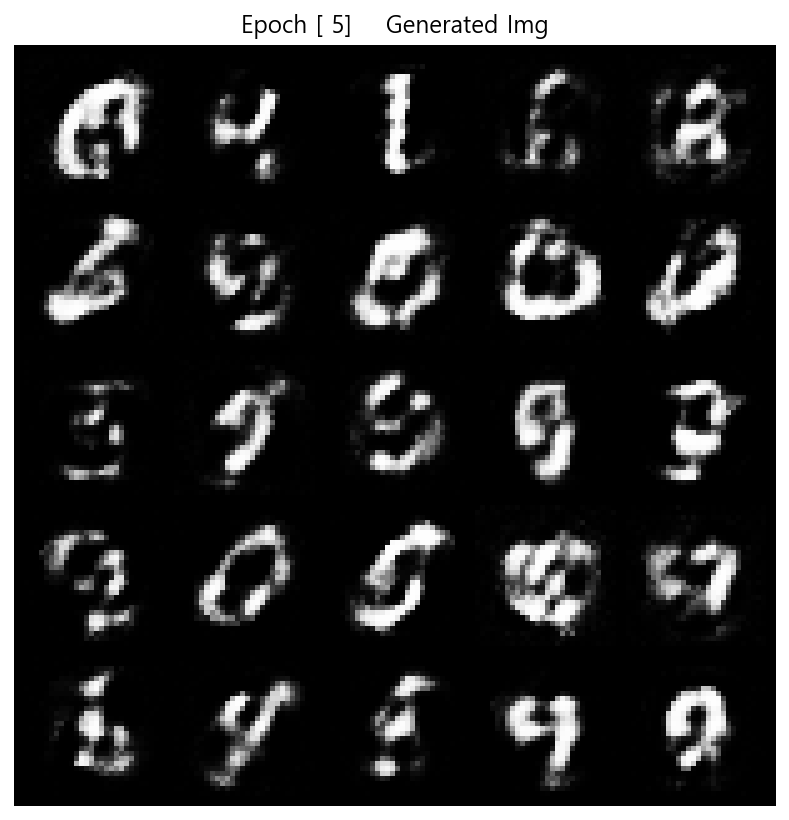

Epoch [ 6|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-9.256858 || 6.810848]    G_Loss -5.725422
Epoch [ 6|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.472068 || -0.089001]    G_Loss 0.625951
Epoch [ 6|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.410894 || 0.881929]    G_Loss -0.907928
Epoch [ 7|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.858849 || -0.835895]    G_Loss 0.987971
Epoch [ 7|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.078559 || 0.146254]    G_Loss 0.036321
Epoch [ 7|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.475777 || 0.400330]    G_Loss -0.644626
Epoch [ 8|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.613938 || -2.846482]    G_Loss 2.540165
Epoch [ 8|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-0.943851 || -1.225983]    G_Loss 1.141479
Epoch [ 8|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.358921 || 1.445579]    G_Loss -1.312433
Epoch [ 9|200]    Ste

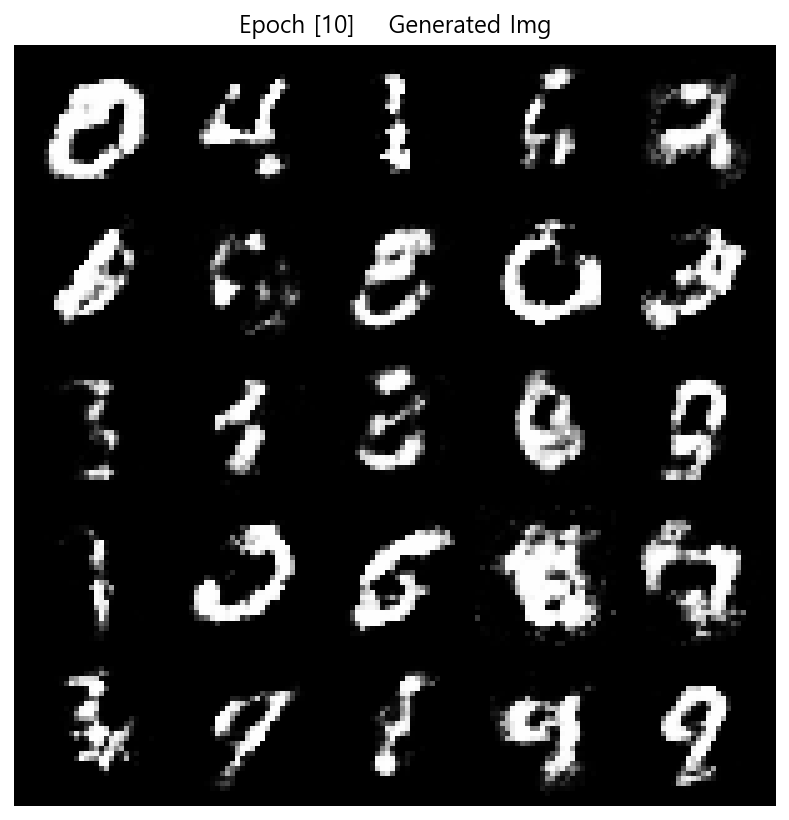

Epoch [11|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.884351 || -0.376449]    G_Loss 0.971497
Epoch [11|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.469180 || 1.391472]    G_Loss -1.354346
Epoch [11|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.832435 || 0.748124]    G_Loss -0.571361
Epoch [12|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.126932 || -0.859176]    G_Loss 0.696140
Epoch [12|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.651431 || 0.571219]    G_Loss -0.650074
Epoch [12|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.142200 || 1.143529]    G_Loss -0.879575
Epoch [13|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.842808 || 2.536088]    G_Loss -2.457530
Epoch [13|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.685770 || -0.301556]    G_Loss 0.206247
Epoch [13|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.596838 || -0.046590]    G_Loss 0.068735
Epoch [14|200]    S

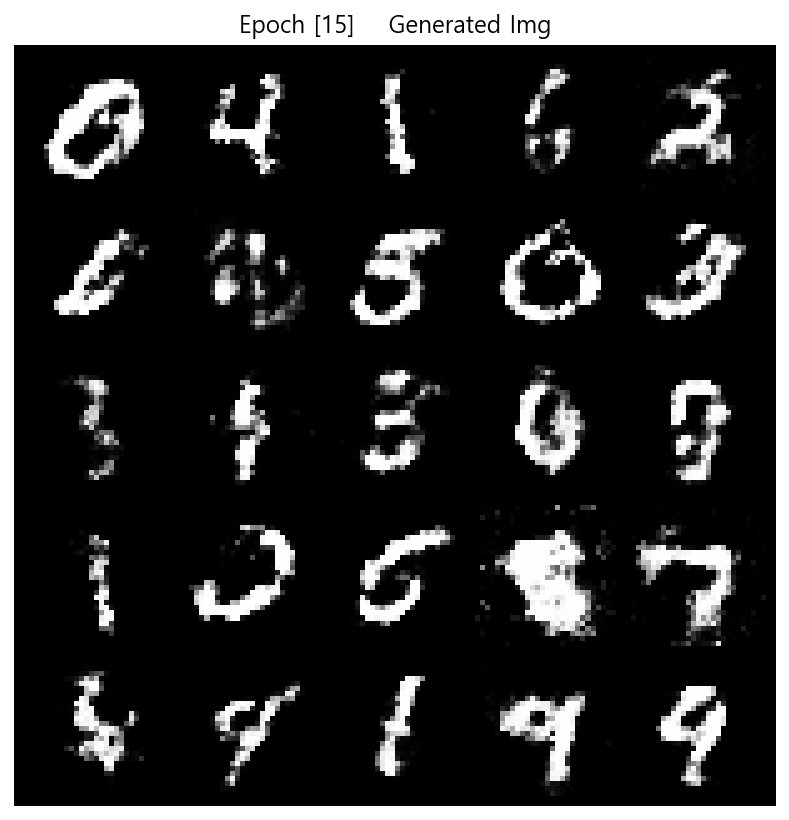

Epoch [16|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.199934 || 1.345817]    G_Loss -0.965849
Epoch [16|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.363134 || 0.686634]    G_Loss -0.523109
Epoch [16|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.292397 || 0.343915]    G_Loss -0.441055
Epoch [17|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.874503 || 1.352350]    G_Loss -0.640223
Epoch [17|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.225683 || 0.340956]    G_Loss 0.106483
Epoch [17|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.092501 || -0.708657]    G_Loss 0.976583
Epoch [18|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.885262 || -0.319112]    G_Loss 0.376285
Epoch [18|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.561838 || 0.810458]    G_Loss -0.185347
Epoch [18|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.597100 || -0.010768]    G_Loss 0.668207
Epoch [19|200]    St

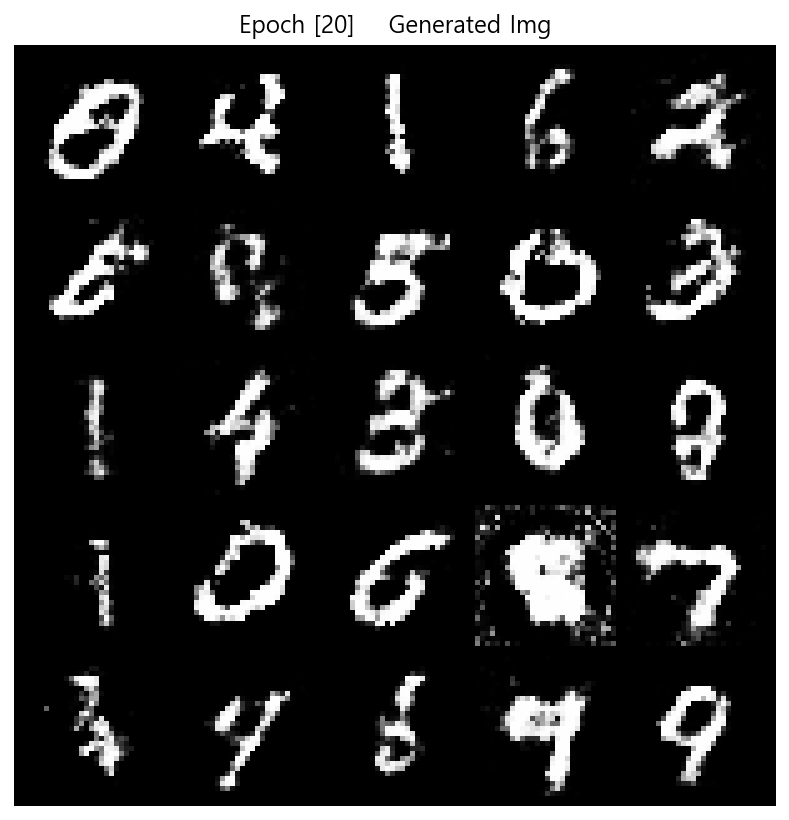

Epoch [21|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.933071 || 0.320803]    G_Loss -0.289926
Epoch [21|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.842234 || 0.256896]    G_Loss 0.035900
Epoch [21|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.781645 || 2.200397]    G_Loss -2.731452
Epoch [22|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.342586 || 0.757559]    G_Loss -0.174551
Epoch [22|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.906598 || 2.171311]    G_Loss -2.504032
Epoch [22|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.311043 || 1.747665]    G_Loss -1.829928
Epoch [23|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.774489 || 3.089236]    G_Loss -2.973254
Epoch [23|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.560652 || -0.349909]    G_Loss 0.792711
Epoch [23|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.770850 || 1.386433]    G_Loss -1.766317
Epoch [24|200]    St

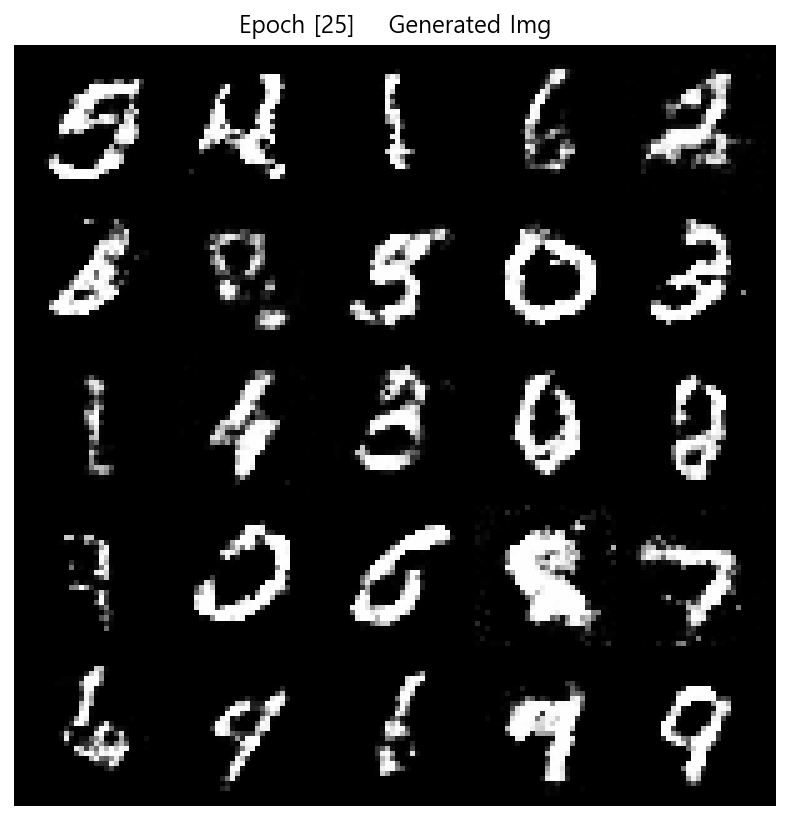

Epoch [26|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.089293 || -0.000237]    G_Loss 0.226572
Epoch [26|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.940596 || 0.464492]    G_Loss -0.186857
Epoch [26|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.697941 || 1.336656]    G_Loss -0.860764
Epoch [27|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.220921 || 0.801567]    G_Loss -1.155490
Epoch [27|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.667851 || 2.255238]    G_Loss -1.351716
Epoch [27|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.291550 || 3.051789]    G_Loss -2.952052
Epoch [28|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.235433 || 1.004249]    G_Loss -0.741869
Epoch [28|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.438366 || 2.142630]    G_Loss -1.955795
Epoch [28|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.187932 || 2.949496]    G_Loss -2.543200
Epoch [29|200]    S

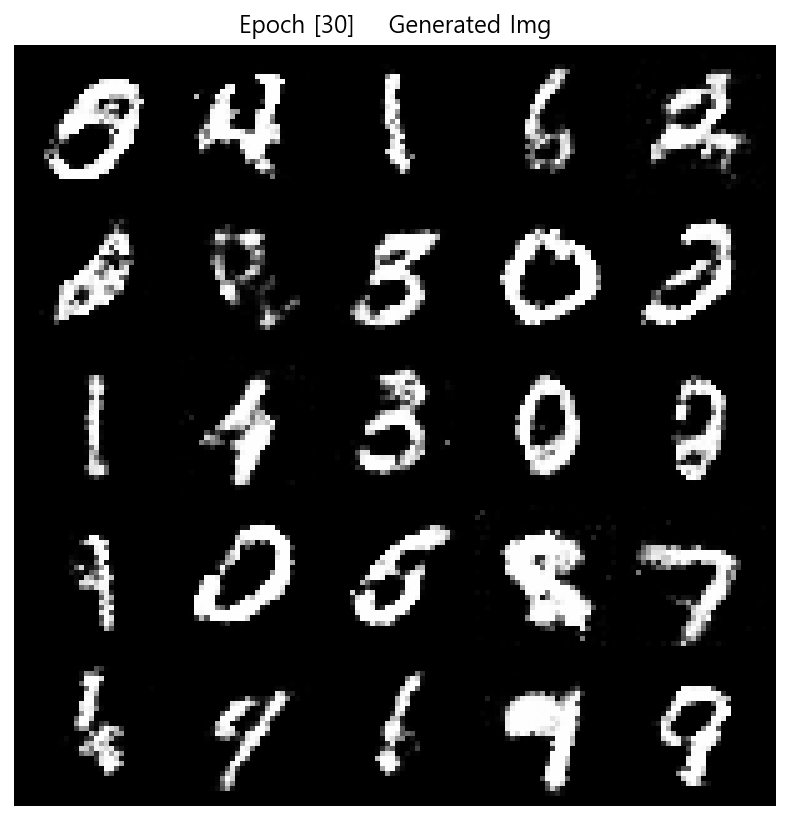

Epoch [31|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.760437 || 1.548943]    G_Loss -0.875309
Epoch [31|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.356995 || 1.132969]    G_Loss -0.461864
Epoch [31|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.927847 || 2.670683]    G_Loss -2.189631
Epoch [32|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.321117 || 0.782834]    G_Loss -0.670426
Epoch [32|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.964237 || 1.344974]    G_Loss -1.277422
Epoch [32|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.343864 || 2.017698]    G_Loss -2.169935
Epoch [33|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.586004 || -0.855098]    G_Loss 1.547289
Epoch [33|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.434180 || 1.280989]    G_Loss -0.582596
Epoch [33|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.192776 || 0.672792]    G_Loss -0.648167
Epoch [34|200]    S

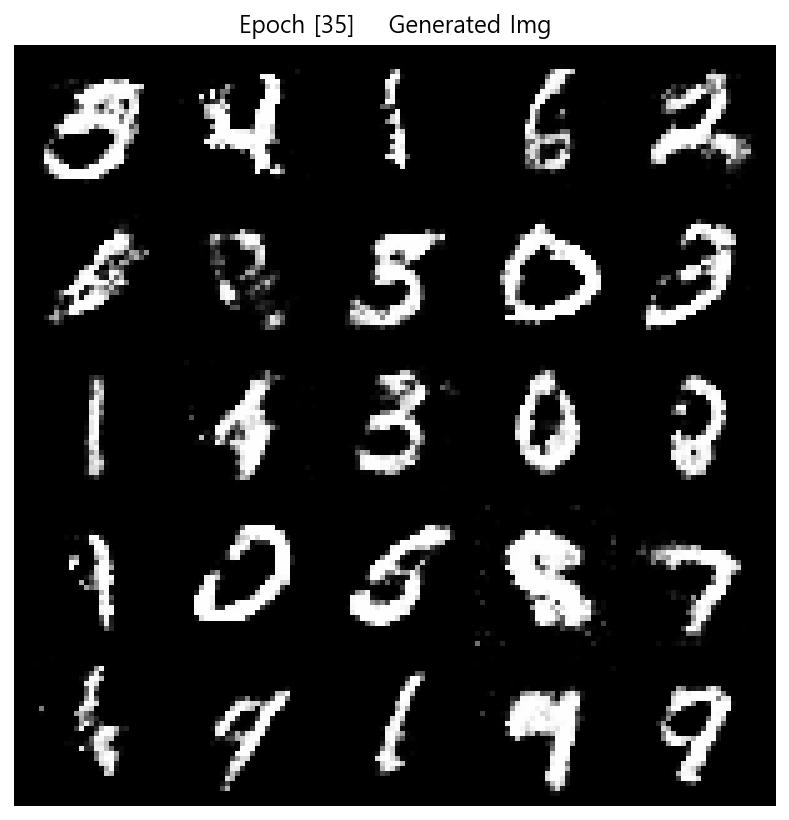

Epoch [36|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.003745 || 3.028981]    G_Loss -3.186258
Epoch [36|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.150373 || 1.798416]    G_Loss -0.711690
Epoch [36|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.836976 || 0.568163]    G_Loss 0.271803
Epoch [37|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-5.809377 || 4.477785]    G_Loss -3.451341
Epoch [37|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.830844 || 0.592151]    G_Loss -0.011235
Epoch [37|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.871770 || 1.706053]    G_Loss -2.394209
Epoch [38|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.662565 || 2.351236]    G_Loss -2.319973
Epoch [38|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-4.923091 || 3.630554]    G_Loss -3.941413
Epoch [38|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.313033 || 1.044050]    G_Loss -1.229603
Epoch [39|200]    St

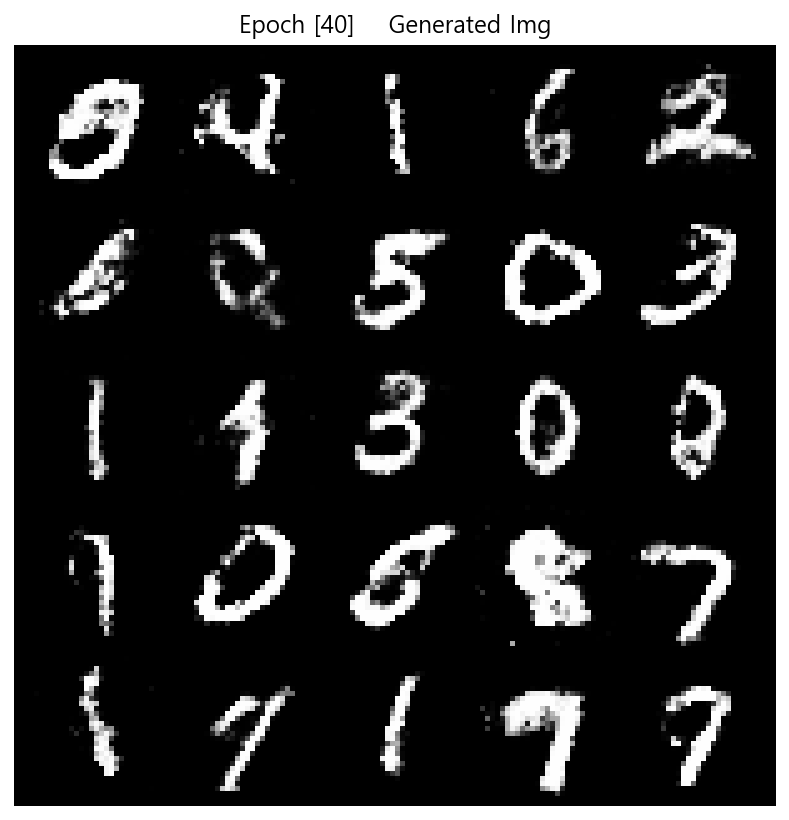

Epoch [41|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.996300 || 1.712708]    G_Loss -1.090338
Epoch [41|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.782243 || 0.558695]    G_Loss -0.371950
Epoch [41|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.240482 || 3.043035]    G_Loss -2.312601
Epoch [42|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.444295 || 2.413890]    G_Loss -2.730810
Epoch [42|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-4.344037 || 3.300303]    G_Loss -3.116078
Epoch [42|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.396697 || 2.361216]    G_Loss -1.522104
Epoch [43|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.413138 || 2.226029]    G_Loss -2.119198
Epoch [43|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.885964 || 0.891167]    G_Loss -0.995207
Epoch [43|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.196762 || 1.157029]    G_Loss -1.058725
Epoch [44|200]    S

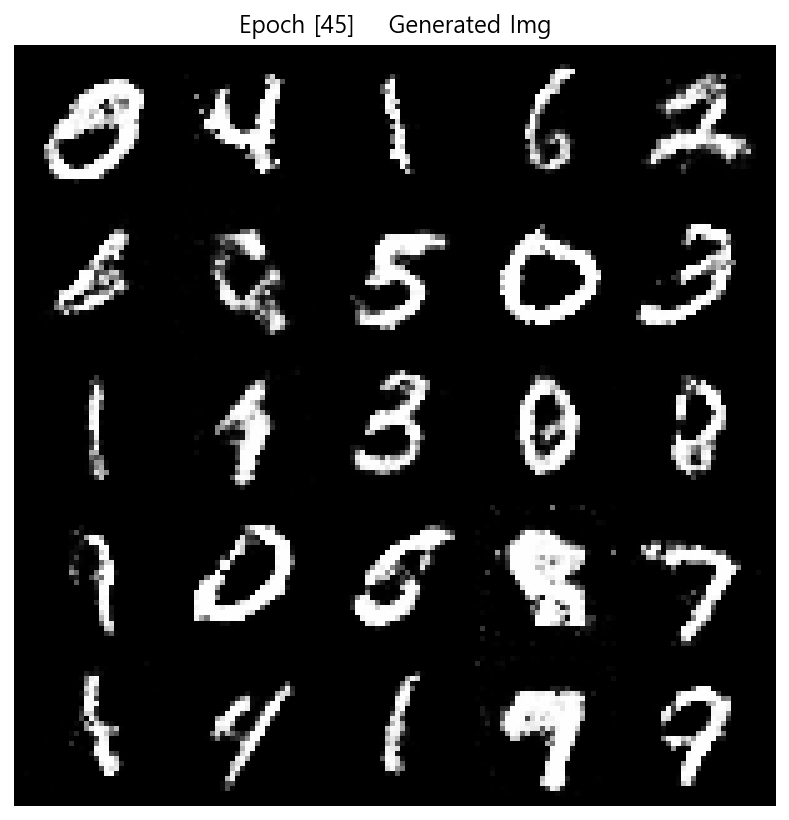

Epoch [46|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.073377 || -1.189275]    G_Loss 1.154372
Epoch [46|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-0.751591 || -0.395264]    G_Loss 0.541579
Epoch [46|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.072998 || -0.149186]    G_Loss 0.845698
Epoch [47|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.412756 || 3.283035]    G_Loss -3.235011
Epoch [47|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.534603 || 1.203621]    G_Loss -1.020673
Epoch [47|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.369113 || 2.917005]    G_Loss -2.786169
Epoch [48|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.105205 || 1.948770]    G_Loss -1.807918
Epoch [48|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.121387 || -0.002805]    G_Loss 0.547569
Epoch [48|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.619984 || 0.502604]    G_Loss -0.349733
Epoch [49|200]    St

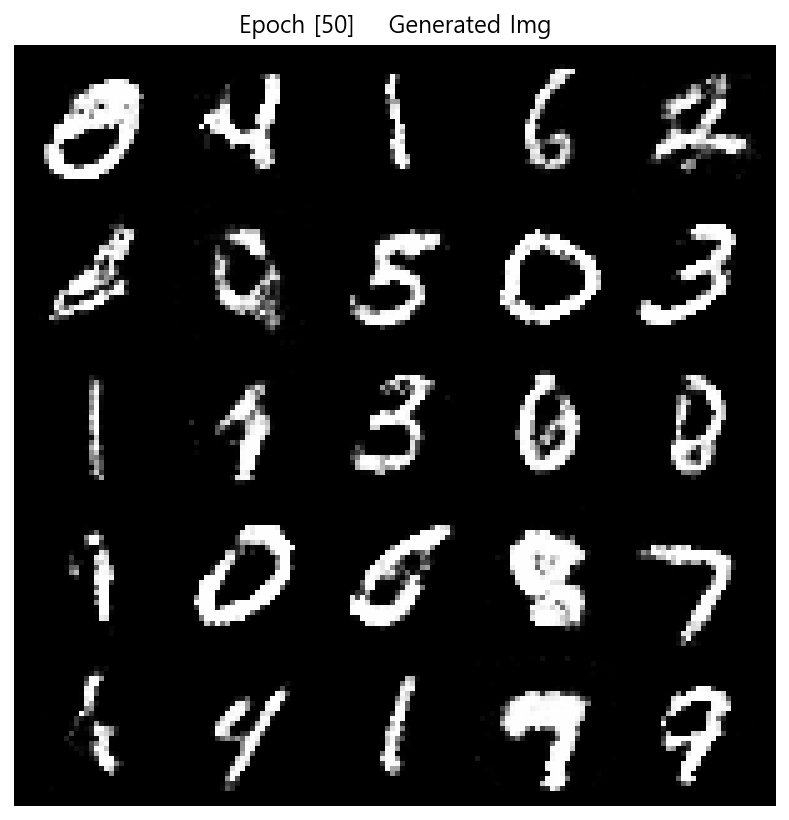

Epoch [51|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.419837 || 1.228569]    G_Loss -1.317248
Epoch [51|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.364117 || 2.091377]    G_Loss -2.210925
Epoch [51|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.305630 || 1.030180]    G_Loss -0.681893
Epoch [52|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.890306 || 0.388626]    G_Loss 0.197158
Epoch [52|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.271450 || 1.192760]    G_Loss -1.058948
Epoch [52|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [0.243360 || -1.362046]    G_Loss 1.493540
Epoch [53|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.909021 || 0.804159]    G_Loss -0.923605
Epoch [53|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.482408 || 2.524094]    G_Loss -2.176026
Epoch [53|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.812146 || 0.769027]    G_Loss -1.217978
Epoch [54|200]    Ste

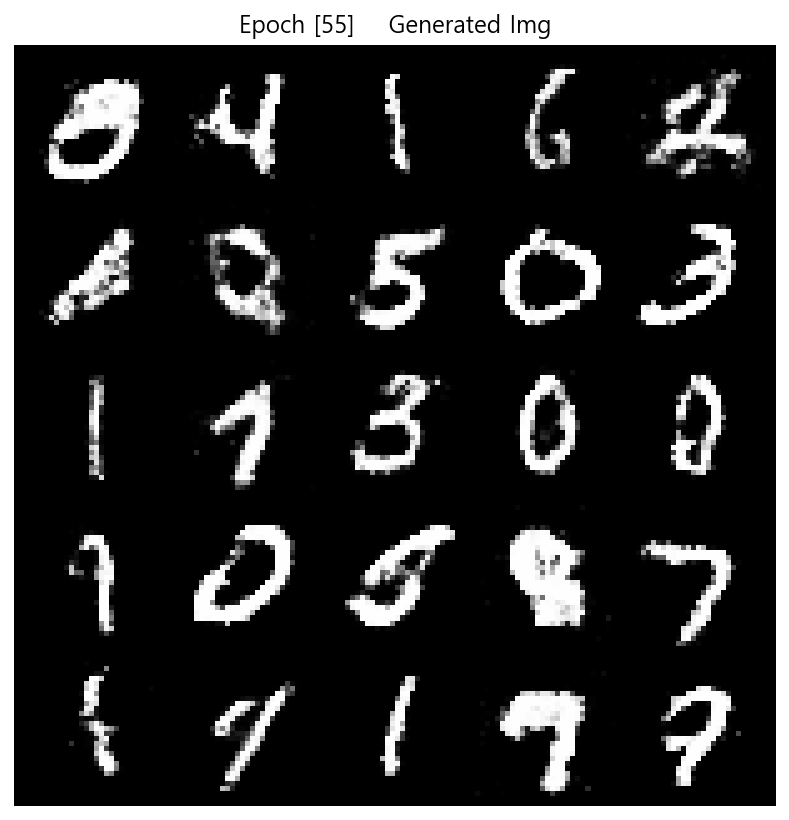

Epoch [56|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.175277 || 0.263573]    G_Loss -0.583464
Epoch [56|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.728357 || 2.267617]    G_Loss -1.737224
Epoch [56|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.365208 || 2.369652]    G_Loss -1.858119
Epoch [57|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.819113 || -0.279242]    G_Loss 0.375041
Epoch [57|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-5.164619 || 4.278528]    G_Loss -4.209155
Epoch [57|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.515807 || 2.362405]    G_Loss -2.337121
Epoch [58|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.480317 || 2.504585]    G_Loss -2.310058
Epoch [58|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.872189 || 0.602525]    G_Loss -0.666478
Epoch [58|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.752493 || -0.655445]    G_Loss 1.249273
Epoch [59|200]    S

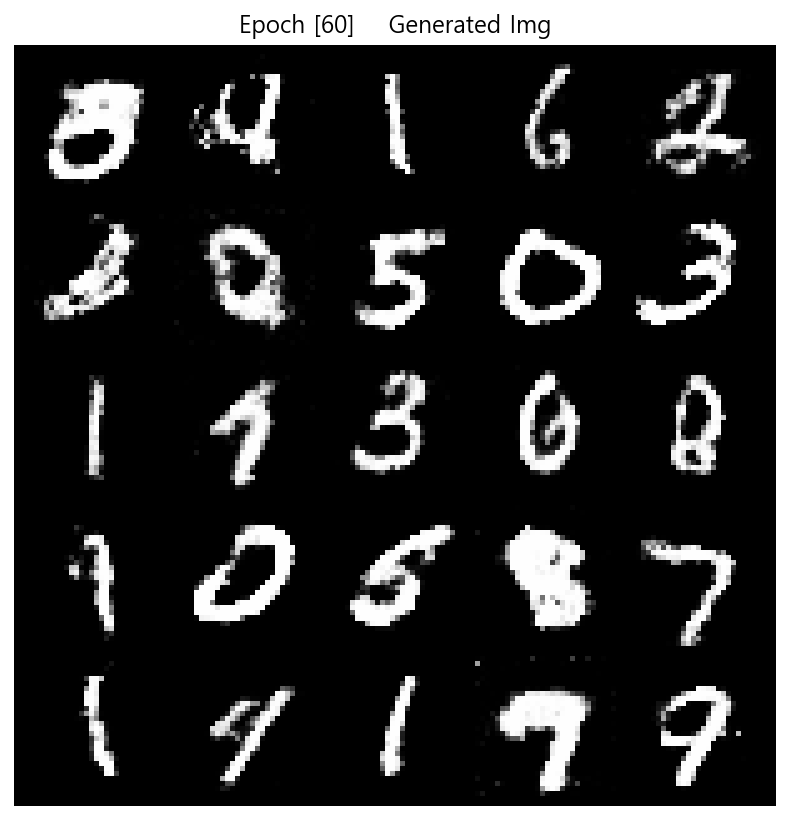

Epoch [61|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.341162 || 1.429945]    G_Loss -1.201237
Epoch [61|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.345303 || 0.014439]    G_Loss 0.342944
Epoch [61|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.994207 || 2.869904]    G_Loss -2.660042
Epoch [62|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.389183 || 1.414315]    G_Loss -1.510234
Epoch [62|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.317678 || 1.013564]    G_Loss -1.153676
Epoch [62|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.478656 || 1.438206]    G_Loss -0.675396
Epoch [63|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.386502 || 0.416256]    G_Loss -0.253825
Epoch [63|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-0.978778 || -0.098073]    G_Loss 0.193736
Epoch [63|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.222466 || 2.211563]    G_Loss -2.321498
Epoch [64|200]    St

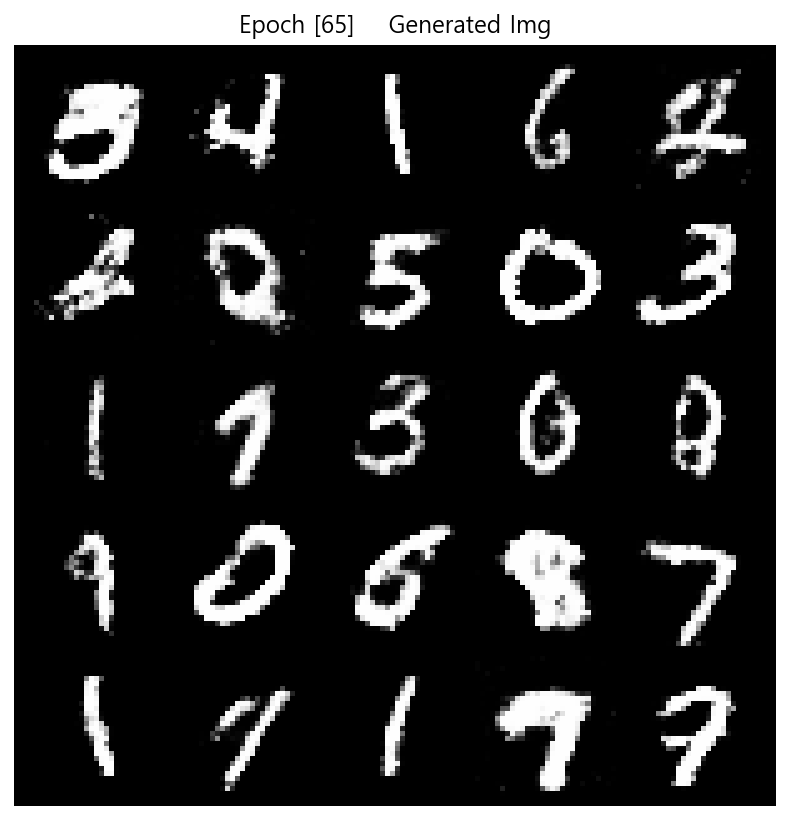

Epoch [66|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.744465 || 1.496315]    G_Loss -1.610988
Epoch [66|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.614728 || 0.488967]    G_Loss 0.225058
Epoch [66|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.748472 || 0.385679]    G_Loss -0.257136
Epoch [67|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.811731 || 0.686240]    G_Loss -0.833984
Epoch [67|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.992423 || 1.819703]    G_Loss -1.777700
Epoch [67|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.709670 || 0.364782]    G_Loss -0.337340
Epoch [68|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.439431 || 0.436051]    G_Loss 0.094661
Epoch [68|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.528645 || 1.360730]    G_Loss -1.582511
Epoch [68|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.009720 || 2.032327]    G_Loss -1.534116
Epoch [69|200]    Ste

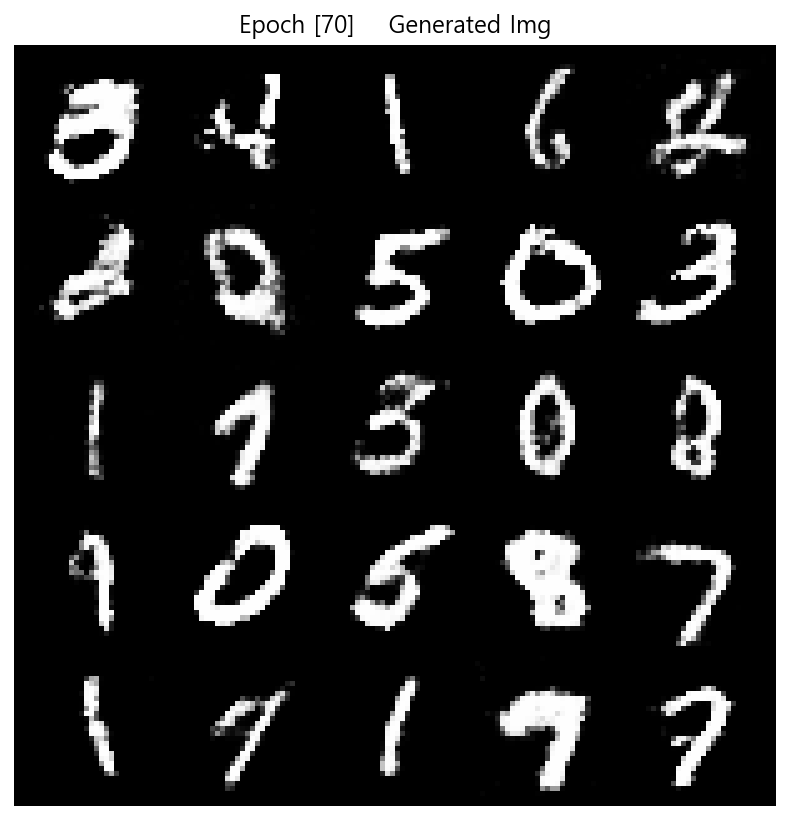

Epoch [71|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.725074 || -0.501315]    G_Loss 0.856704
Epoch [71|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.396732 || 2.342334]    G_Loss -2.194279
Epoch [71|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.152343 || -0.905640]    G_Loss 1.104506
Epoch [72|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.658658 || 1.548419]    G_Loss -1.490796
Epoch [72|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-0.131961 || -0.458077]    G_Loss 0.324143
Epoch [72|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.327987 || 0.057105]    G_Loss 0.433076
Epoch [73|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.530993 || 1.501984]    G_Loss -1.871015
Epoch [73|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.035096 || 1.862469]    G_Loss -1.744291
Epoch [73|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.069152 || 2.145331]    G_Loss -2.001137
Epoch [74|200]    St

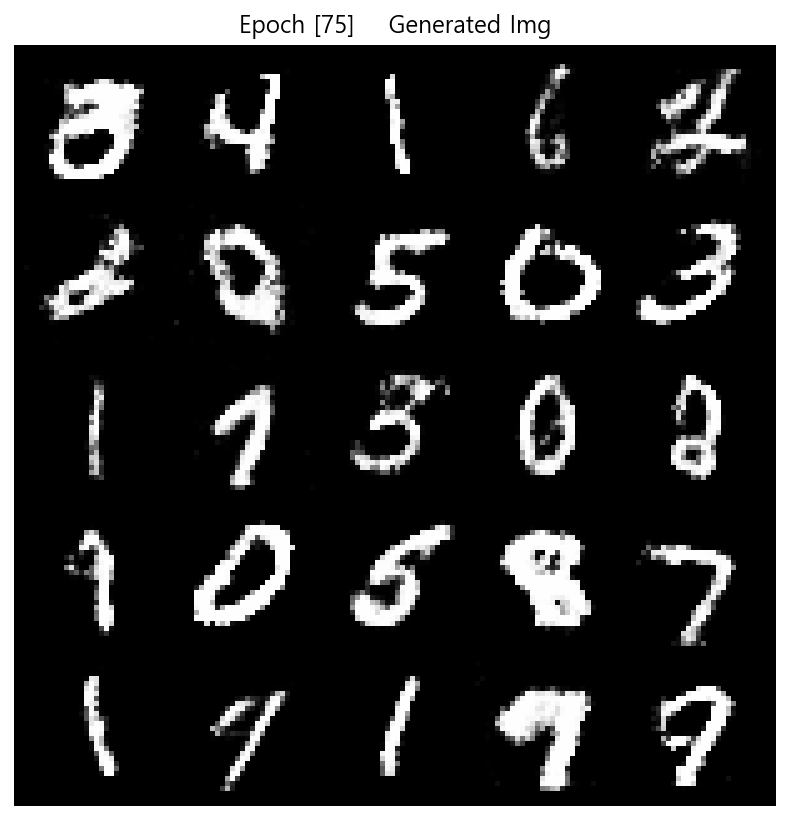

Epoch [76|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.986113 || 1.009612]    G_Loss -1.313790
Epoch [76|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.266874 || 1.509436]    G_Loss -1.307857
Epoch [76|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.125167 || -0.897452]    G_Loss 0.977434
Epoch [77|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.813565 || 0.920017]    G_Loss -1.126817
Epoch [77|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.011357 || -0.045706]    G_Loss 0.629798
Epoch [77|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.942528 || 1.872992]    G_Loss -1.732982
Epoch [78|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.309314 || 1.259451]    G_Loss -0.902519
Epoch [78|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.031035 || 1.891772]    G_Loss -1.710019
Epoch [78|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.631724 || 1.843004]    G_Loss -2.032636
Epoch [79|200]    S

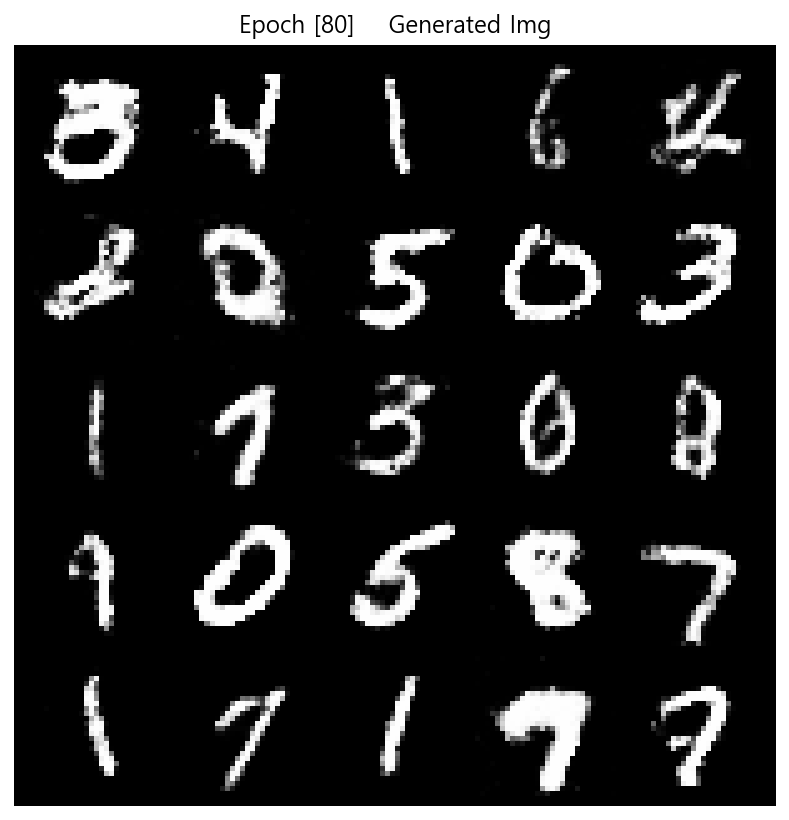

Epoch [81|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.164497 || -1.231199]    G_Loss 1.750904
Epoch [81|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.068656 || 2.170837]    G_Loss -2.129402
Epoch [81|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.408710 || 2.086044]    G_Loss -1.551170
Epoch [82|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.905793 || 1.080529]    G_Loss -0.876228
Epoch [82|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-0.540673 || -0.585409]    G_Loss 0.844355
Epoch [82|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.817623 || -0.075857]    G_Loss -0.026695
Epoch [83|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.738368 || -1.765269]    G_Loss 2.348155
Epoch [83|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.756905 || 1.575048]    G_Loss -1.005017
Epoch [83|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.531281 || -0.310462]    G_Loss 0.625126
Epoch [84|200]    St

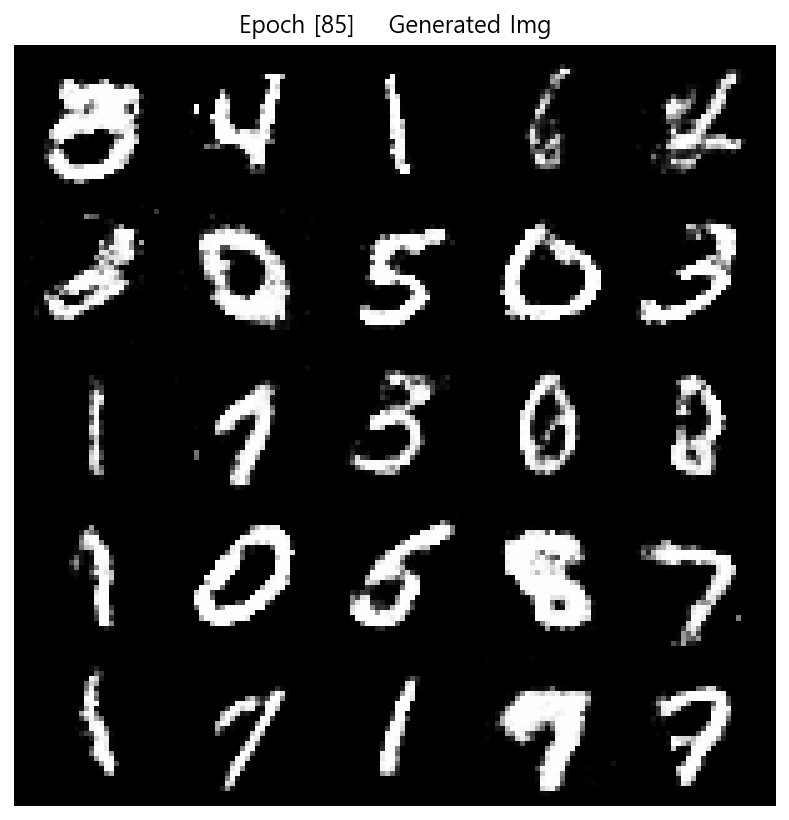

Epoch [86|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.827974 || 1.828931]    G_Loss -1.802572
Epoch [86|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.491823 || 1.543791]    G_Loss -1.222764
Epoch [86|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.770455 || 2.599473]    G_Loss -2.230766
Epoch [87|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.101715 || 1.237405]    G_Loss -0.806405
Epoch [87|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [1.013501 || -2.005646]    G_Loss 2.261229
Epoch [87|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.054768 || -0.132145]    G_Loss 0.107588
Epoch [88|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.736227 || 0.941677]    G_Loss -0.052084
Epoch [88|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.165020 || 2.201435]    G_Loss -2.003044
Epoch [88|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.440536 || 1.517238]    G_Loss -1.174030
Epoch [89|200]    St

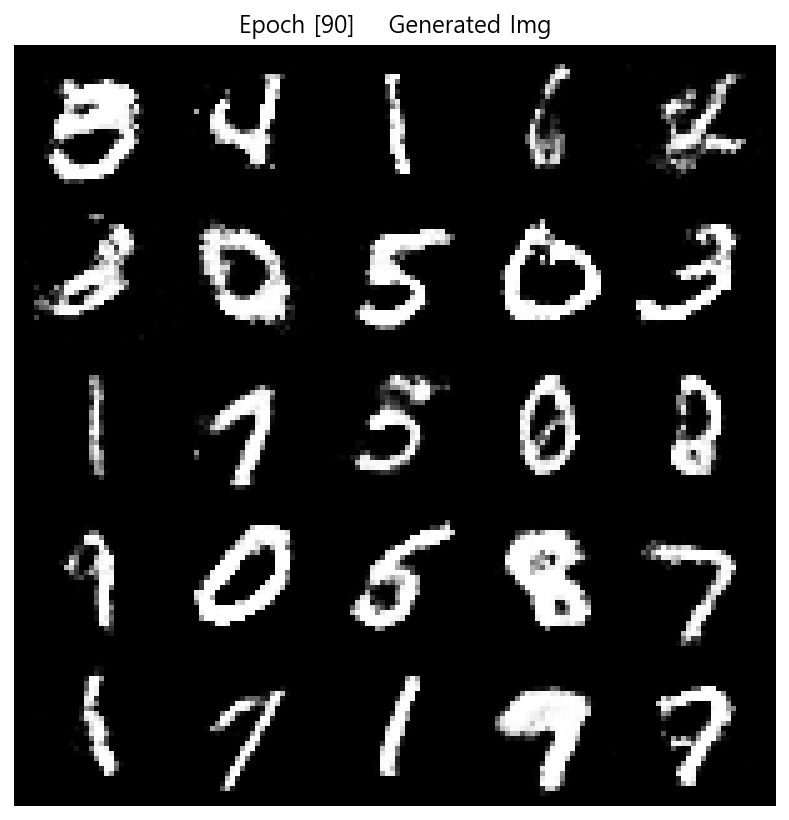

Epoch [91|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.437245 || 2.520047]    G_Loss -2.205826
Epoch [91|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.700430 || 2.055586]    G_Loss -1.480943
Epoch [91|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.451019 || 1.427129]    G_Loss -1.127337
Epoch [92|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.966599 || 1.193329]    G_Loss -0.937929
Epoch [92|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.634033 || 0.520949]    G_Loss -0.430015
Epoch [92|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.391104 || 1.405641]    G_Loss -1.055230
Epoch [93|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.457282 || 0.516372]    G_Loss -0.314912
Epoch [93|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.336351 || 1.621885]    G_Loss -1.403043
Epoch [93|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.851522 || -0.114790]    G_Loss 0.168109
Epoch [94|200]    S

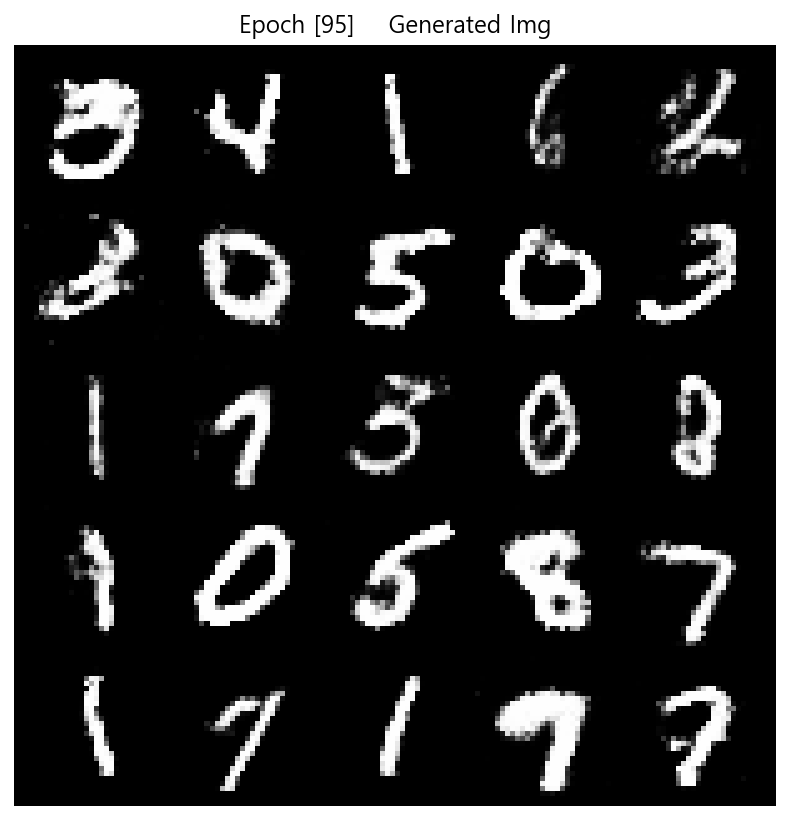

Epoch [96|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.238137 || 0.242105]    G_Loss -0.331834
Epoch [96|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.960039 || 1.020751]    G_Loss -0.748306
Epoch [96|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.429299 || 2.421763]    G_Loss -2.053695
Epoch [97|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.981254 || 1.053280]    G_Loss -0.800196
Epoch [97|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.323006 || 2.330016]    G_Loss -2.368579
Epoch [97|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.802727 || 0.656694]    G_Loss 0.173283
Epoch [98|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.887028 || 0.922656]    G_Loss -0.700606
Epoch [98|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.384450 || 0.565617]    G_Loss -0.290085
Epoch [98|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.202235 || 1.169407]    G_Loss -0.885859
Epoch [99|200]    St

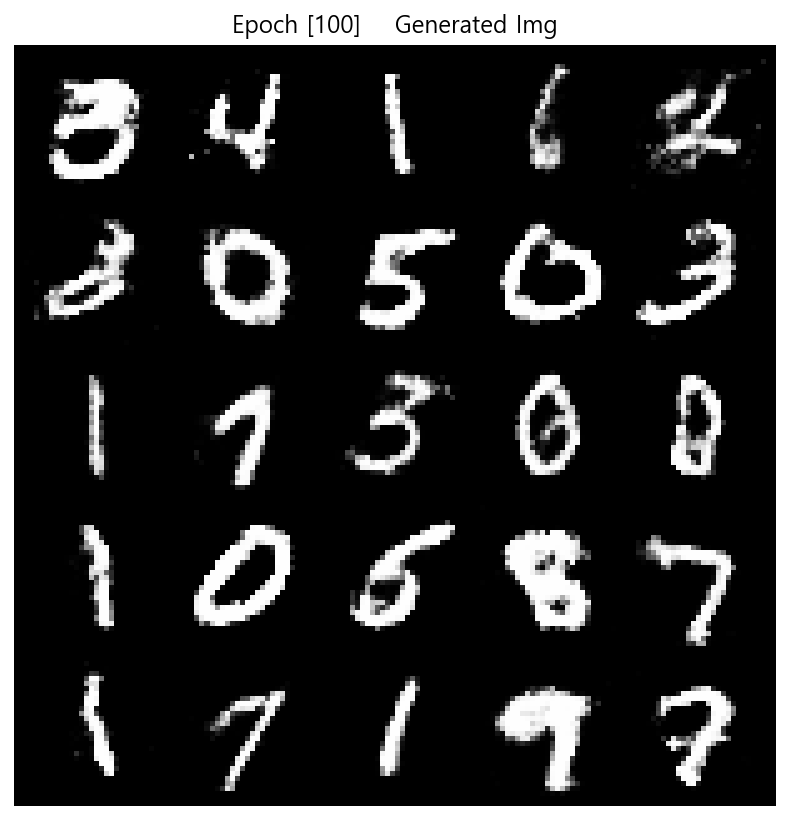

Epoch [101|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.064775 || 0.303910]    G_Loss -0.281770
Epoch [101|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.647944 || 0.323928]    G_Loss 0.640987
Epoch [101|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.867657 || -0.369654]    G_Loss 0.315880
Epoch [102|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.037614 || 0.977587]    G_Loss -0.680016
Epoch [102|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.079550 || 1.131184]    G_Loss -1.059207
Epoch [102|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.695014 || 1.728755]    G_Loss -2.086944
Epoch [103|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.788782 || 0.742097]    G_Loss -0.334121
Epoch [103|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.076563 || 1.137317]    G_Loss -0.737157
Epoch [103|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.390084 || 1.445932]    G_Loss -1.399971
Epoch [104|

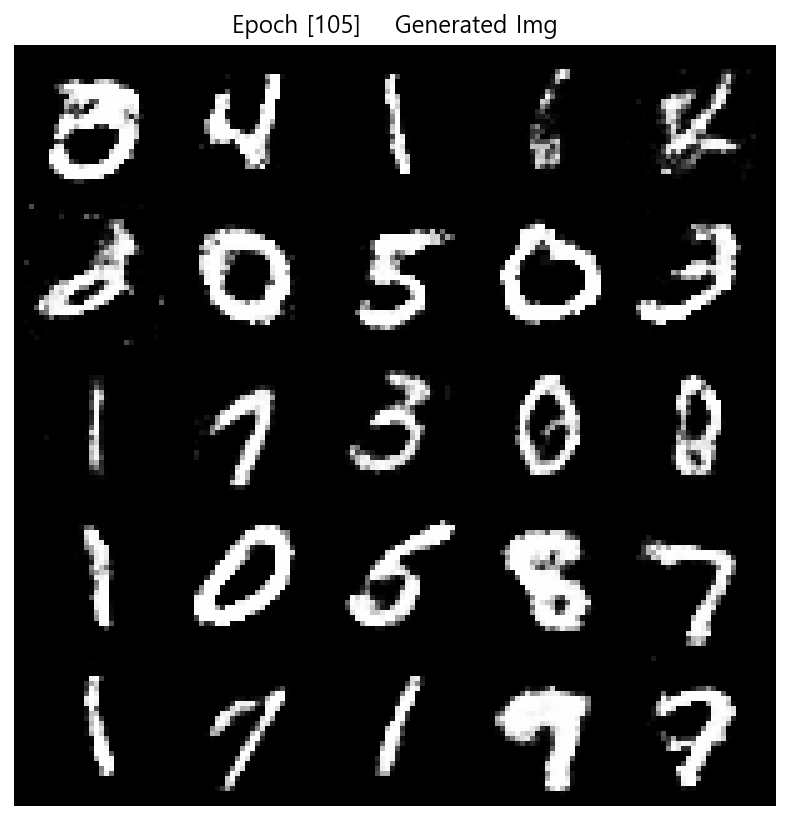

Epoch [106|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.674822 || 0.763714]    G_Loss -0.865128
Epoch [106|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.248603 || 1.488419]    G_Loss -1.644586
Epoch [106|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.530306 || 1.789783]    G_Loss -1.812420
Epoch [107|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.441022 || 3.560445]    G_Loss -3.192395
Epoch [107|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.937485 || 1.028392]    G_Loss -0.693835
Epoch [107|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.762482 || 1.901742]    G_Loss -1.255789
Epoch [108|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.946214 || -0.132979]    G_Loss 0.316291
Epoch [108|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [0.043106 || -0.981371]    G_Loss 1.228258
Epoch [108|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.064409 || 2.181191]    G_Loss -2.195548
Epoch [109|

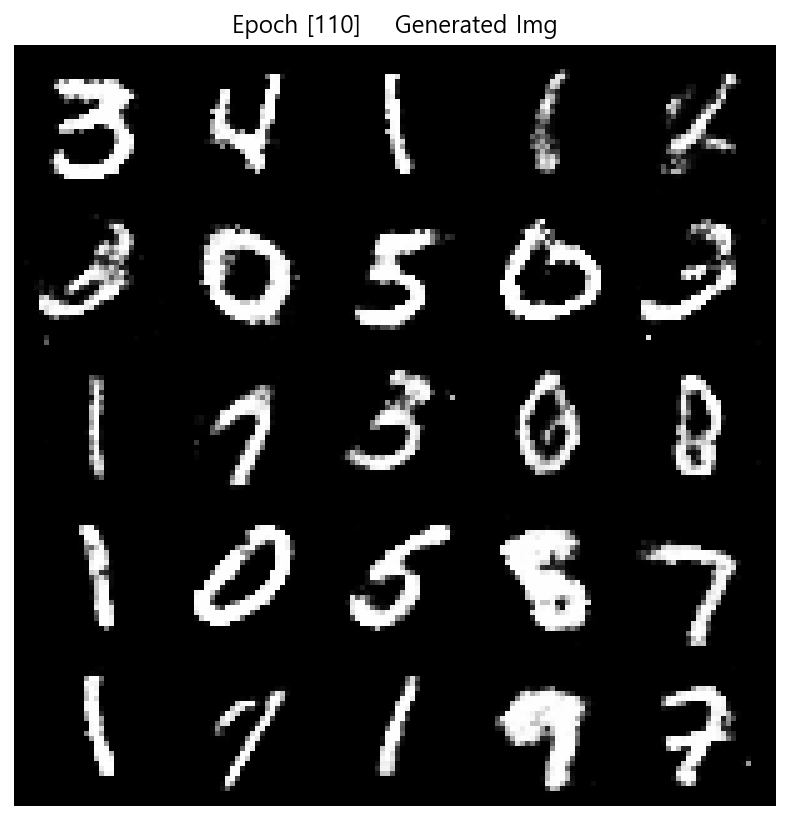

Epoch [111|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.030434 || -0.972403]    G_Loss 1.143837
Epoch [111|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.450086 || 0.482955]    G_Loss -0.530771
Epoch [111|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.071346 || 1.061012]    G_Loss -0.597891
Epoch [112|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.730436 || 1.556932]    G_Loss -1.682093
Epoch [112|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.611710 || 2.614846]    G_Loss -2.322885
Epoch [112|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.626486 || 0.924238]    G_Loss -0.666760
Epoch [113|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.011107 || 0.251094]    G_Loss -0.472459
Epoch [113|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.107545 || 1.172307]    G_Loss -1.013119
Epoch [113|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.026142 || -1.150167]    G_Loss 1.362904
Epoch [114|

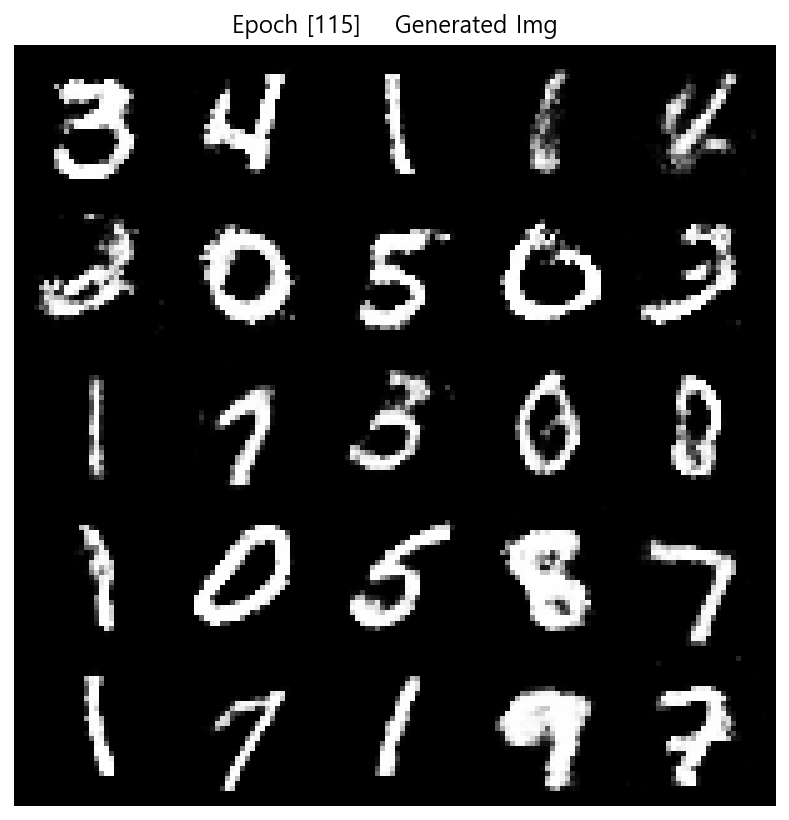

Epoch [116|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.353254 || 0.596411]    G_Loss -0.371203
Epoch [116|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.707535 || 0.943049]    G_Loss -1.086204
Epoch [116|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.095993 || 2.251339]    G_Loss -1.972074
Epoch [117|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.604714 || 0.829130]    G_Loss -1.212634
Epoch [117|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.532148 || 1.688343]    G_Loss -1.627024
Epoch [117|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.118472 || 1.974413]    G_Loss -1.479985
Epoch [118|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.125062 || 2.190477]    G_Loss -1.991883
Epoch [118|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.564434 || 0.363358]    G_Loss 0.049188
Epoch [118|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.905068 || 0.914157]    G_Loss -0.574422
Epoch [119|

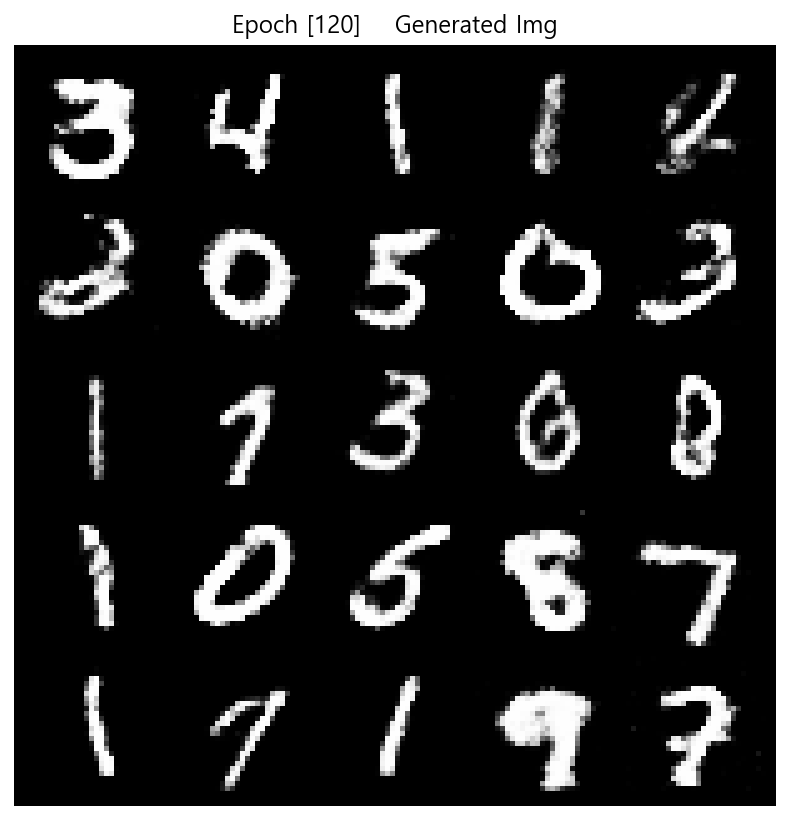

Epoch [121|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.127560 || 1.276928]    G_Loss -1.251288
Epoch [121|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.798266 || 0.649402]    G_Loss -0.256906
Epoch [121|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.706167 || 1.724266]    G_Loss -1.663662
Epoch [122|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.864421 || 2.045612]    G_Loss -1.830019
Epoch [122|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.975168 || 1.287397]    G_Loss -1.183012
Epoch [122|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.646959 || 2.646582]    G_Loss -2.451760
Epoch [123|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.693293 || 0.725479]    G_Loss -0.576957
Epoch [123|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.489164 || 1.480828]    G_Loss -1.270721
Epoch [123|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.792613 || 1.861904]    G_Loss -1.510473
Epoch [124

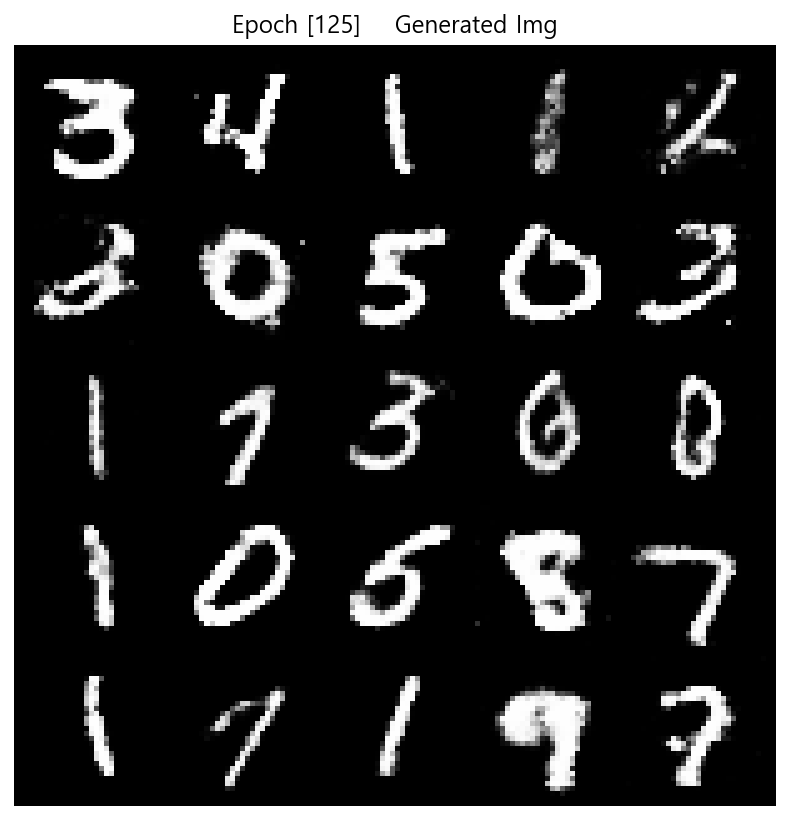

Epoch [126|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.069979 || 1.056627]    G_Loss -0.891328
Epoch [126|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.561392 || 1.653399]    G_Loss -1.344674
Epoch [126|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.225343 || 1.328260]    G_Loss -1.036222
Epoch [127|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.762955 || 0.676177]    G_Loss -0.486261
Epoch [127|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.327139 || 0.417825]    G_Loss -0.294707
Epoch [127|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.820208 || 1.971566]    G_Loss -1.839459
Epoch [128|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.864969 || 1.924854]    G_Loss -1.461802
Epoch [128|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.317696 || 1.470322]    G_Loss -1.423282
Epoch [128|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.160522 || 1.497064]    G_Loss -1.078185
Epoch [129

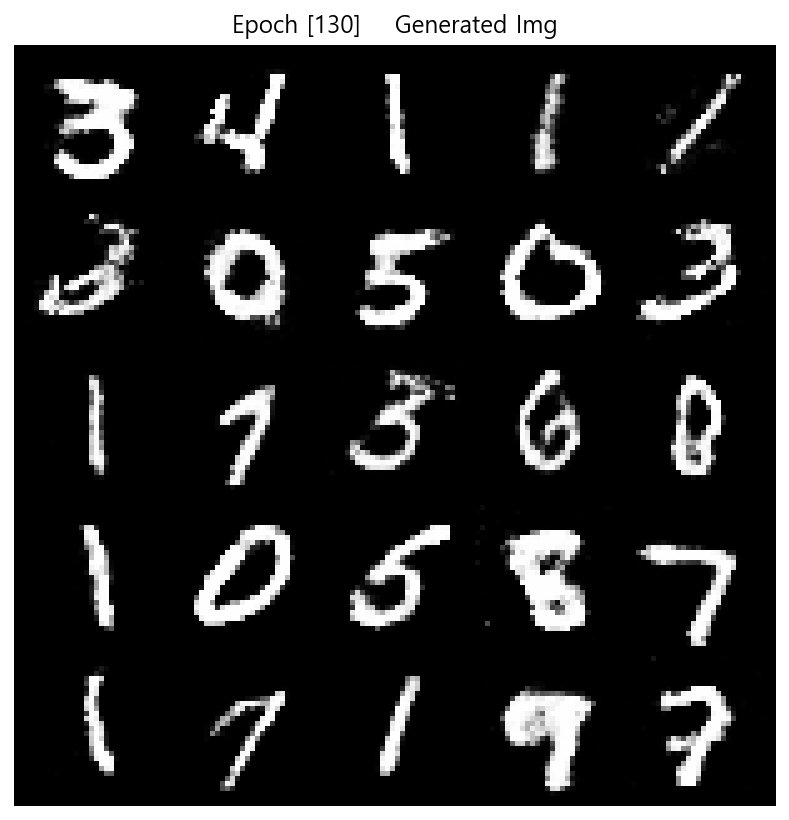

Epoch [131|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.158194 || 0.310912]    G_Loss -0.067712
Epoch [131|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.109771 || 1.049403]    G_Loss -0.634367
Epoch [131|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-0.676226 || -0.244739]    G_Loss 0.198108
Epoch [132|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.600601 || 2.879225]    G_Loss -2.813362
Epoch [132|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.805035 || 1.852201]    G_Loss -1.573319
Epoch [132|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.032469 || 1.945338]    G_Loss -1.808550
Epoch [133|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.104728 || 0.383864]    G_Loss -0.504384
Epoch [133|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.835049 || 0.776896]    G_Loss -0.792577
Epoch [133|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.835999 || 1.898447]    G_Loss -1.938778
Epoch [134

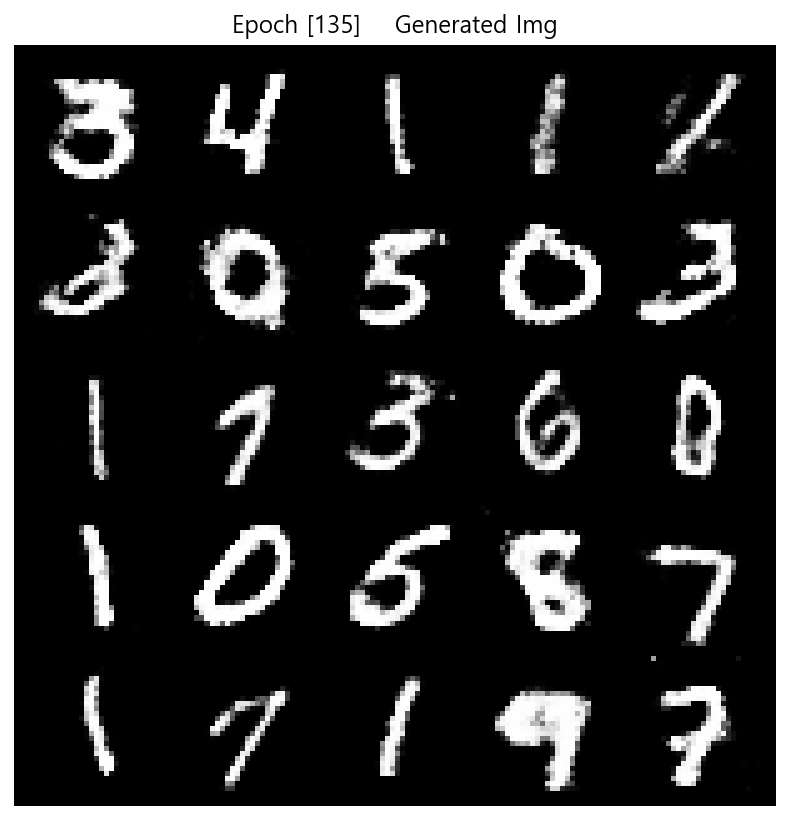

Epoch [136|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.693473 || 1.674467]    G_Loss -1.442940
Epoch [136|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.490054 || 2.686528]    G_Loss -2.725081
Epoch [136|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.824244 || 3.169065]    G_Loss -2.918673
Epoch [137|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.201468 || 2.363634]    G_Loss -2.112263
Epoch [137|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-4.009430 || 3.350194]    G_Loss -2.947263
Epoch [137|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.940431 || 2.036919]    G_Loss -1.950374
Epoch [138|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.480232 || 0.743780]    G_Loss -0.451046
Epoch [138|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.702219 || 1.521235]    G_Loss -1.116811
Epoch [138|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.162291 || 2.375581]    G_Loss -2.325040
Epoch [139

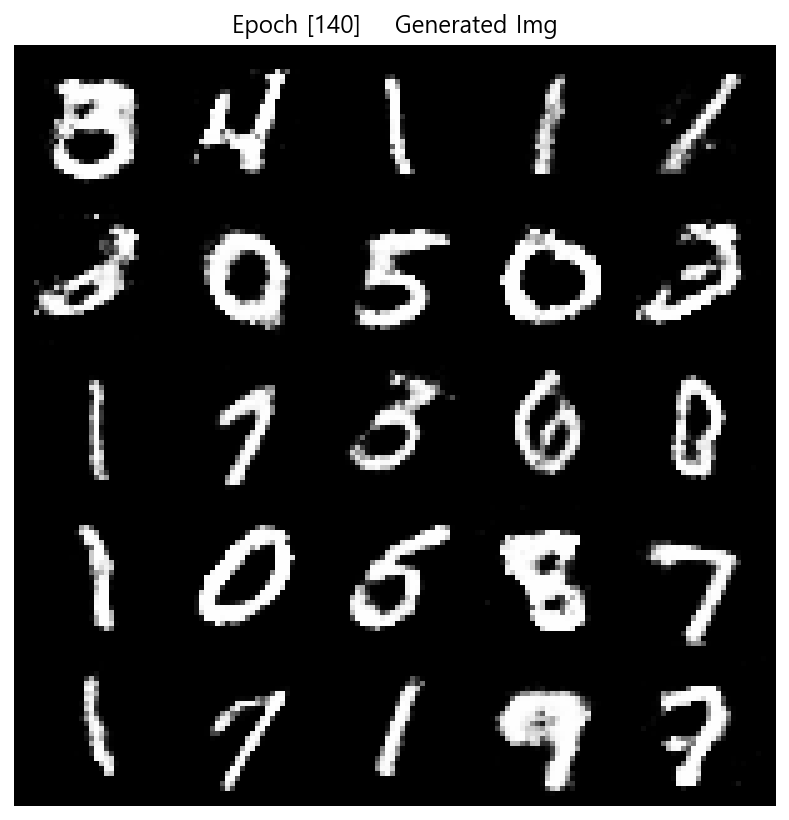

Epoch [141|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.769259 || 2.982573]    G_Loss -2.626289
Epoch [141|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.787554 || 1.725581]    G_Loss -1.332489
Epoch [141|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.987197 || 2.143725]    G_Loss -1.802616
Epoch [142|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.975272 || 1.408313]    G_Loss -1.375244
Epoch [142|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.474053 || 1.737657]    G_Loss -1.585015
Epoch [142|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.443358 || 2.563560]    G_Loss -2.194992
Epoch [143|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.077166 || 2.273033]    G_Loss -1.835638
Epoch [143|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.867102 || 0.913709]    G_Loss -0.775283
Epoch [143|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.545235 || 1.722631]    G_Loss -1.597726
Epoch [144

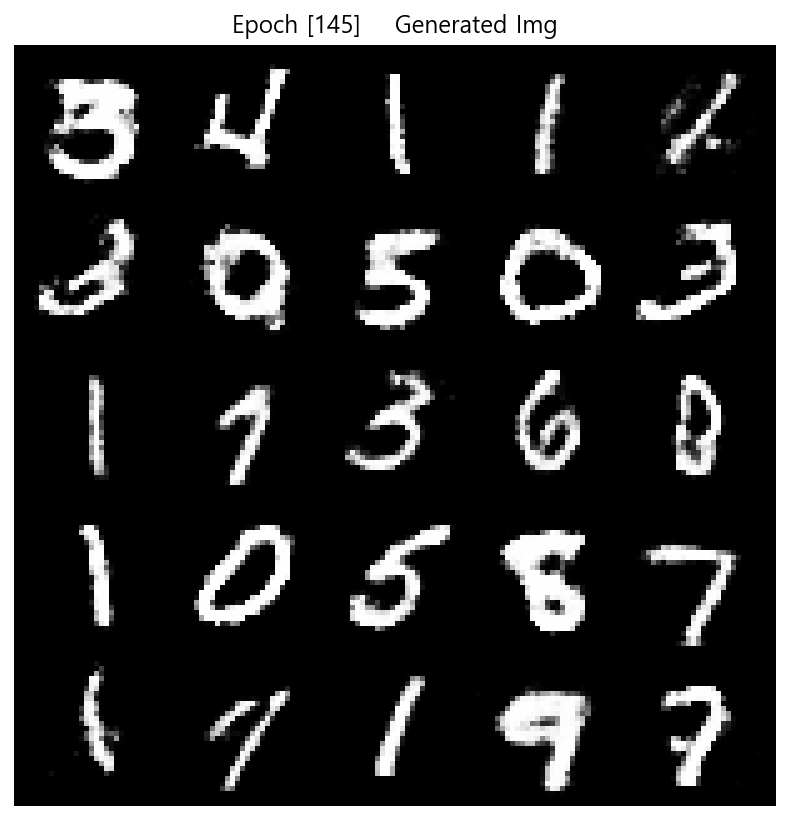

Epoch [146|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.657211 || 0.736788]    G_Loss -0.474378
Epoch [146|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.100569 || 1.088122]    G_Loss -1.090743
Epoch [146|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.024056 || 3.169279]    G_Loss -2.992712
Epoch [147|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.198682 || 3.385159]    G_Loss -3.384096
Epoch [147|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.335747 || 2.198939]    G_Loss -1.688960
Epoch [147|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.422832 || 0.597668]    G_Loss -0.137455
Epoch [148|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.593966 || 1.911142]    G_Loss -1.525176
Epoch [148|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.259762 || 2.344196]    G_Loss -2.156862
Epoch [148|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.245328 || 2.526443]    G_Loss -2.569425
Epoch [149

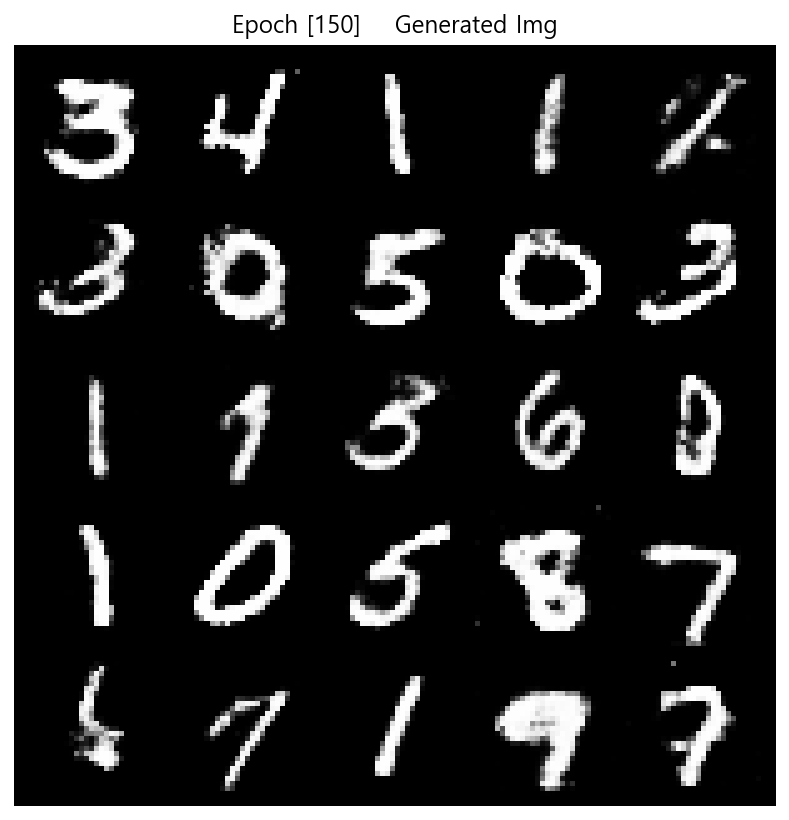

Epoch [151|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.403610 || 1.372250]    G_Loss -1.323715
Epoch [151|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.771660 || 0.821970]    G_Loss -0.487535
Epoch [151|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.036274 || 1.113843]    G_Loss -0.752531
Epoch [152|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.461626 || 1.482775]    G_Loss -1.182193
Epoch [152|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.003358 || 1.252206]    G_Loss -0.739477
Epoch [152|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.402143 || 0.547430]    G_Loss -0.287772
Epoch [153|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.113190 || 2.569443]    G_Loss -2.363709
Epoch [153|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.787940 || 0.980547]    G_Loss -0.445692
Epoch [153|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.303599 || 1.639174]    G_Loss -1.114915
Epoch [154

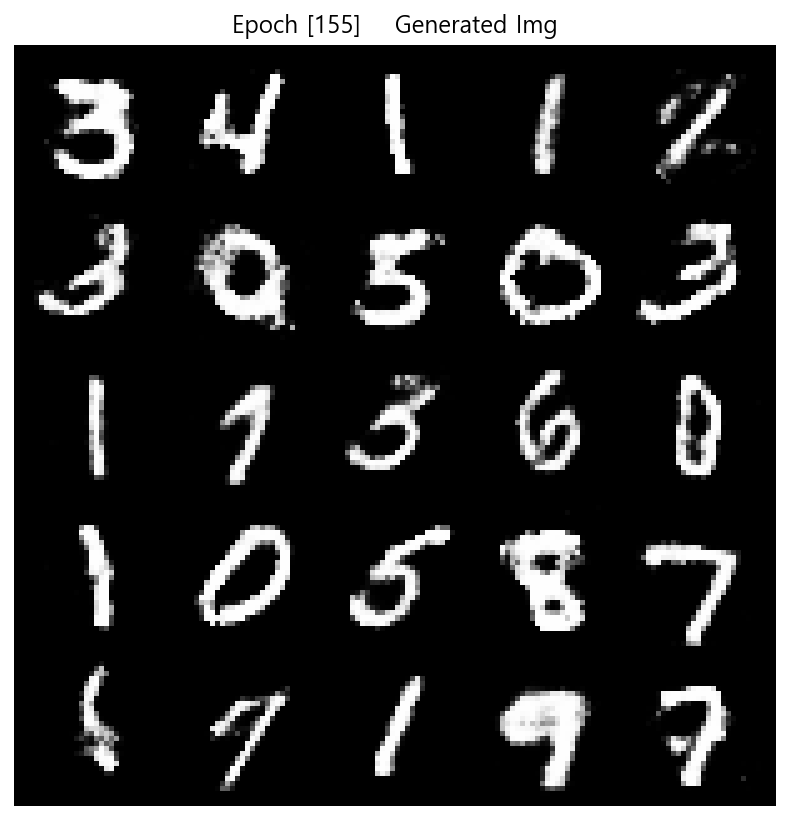

Epoch [156|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.971415 || 1.205500]    G_Loss -0.750175
Epoch [156|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.512456 || 2.526957]    G_Loss -2.190017
Epoch [156|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.269010 || 2.554080]    G_Loss -2.074744
Epoch [157|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.472597 || 1.703965]    G_Loss -1.506678
Epoch [157|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.840274 || 3.103233]    G_Loss -2.802640
Epoch [157|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.102604 || 2.303808]    G_Loss -1.957999
Epoch [158|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.674858 || 0.854583]    G_Loss -0.964906
Epoch [158|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.716904 || 2.154558]    G_Loss -2.214886
Epoch [158|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.800434 || 2.024092]    G_Loss -1.799604
Epoch [159

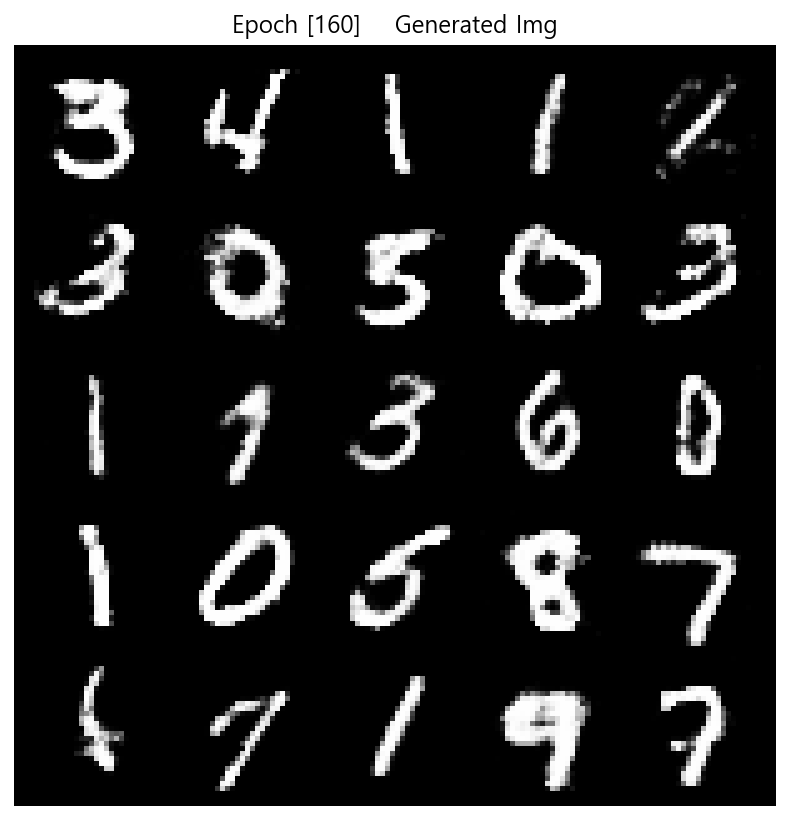

Epoch [161|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.917476 || 1.027720]    G_Loss -0.582387
Epoch [161|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.363270 || 1.673917]    G_Loss -1.664012
Epoch [161|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.668879 || 2.001627]    G_Loss -1.779066
Epoch [162|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.957691 || 1.329106]    G_Loss -0.919980
Epoch [162|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.080302 || 1.377396]    G_Loss -1.337348
Epoch [162|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.975017 || 1.180168]    G_Loss -0.809409
Epoch [163|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.213843 || 3.304280]    G_Loss -3.028288
Epoch [163|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.715387 || 2.032291]    G_Loss -2.234567
Epoch [163|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.096246 || 2.311665]    G_Loss -2.379651
Epoch [164

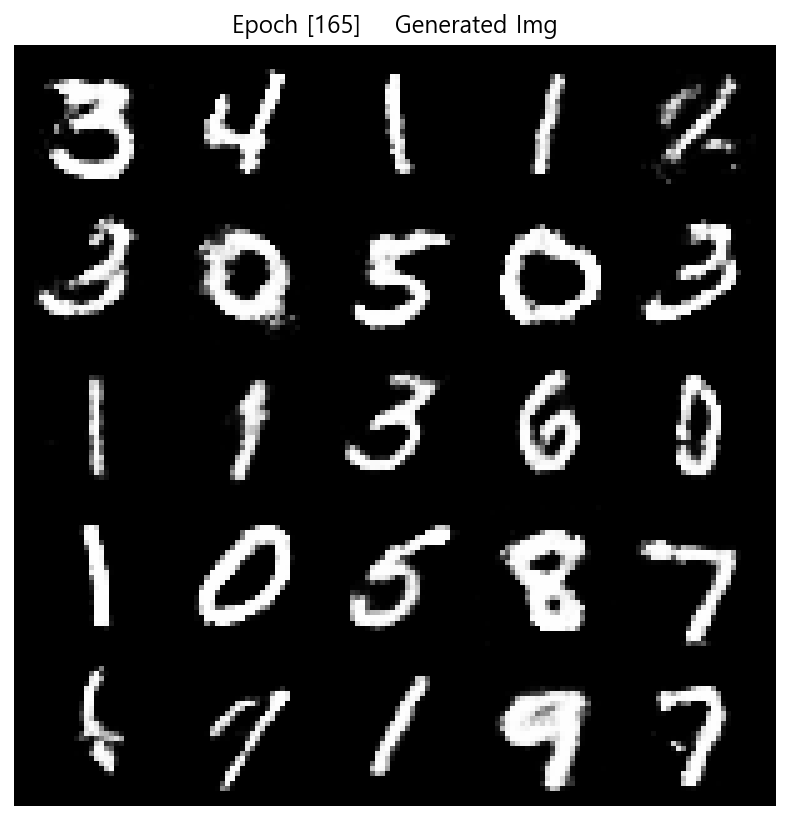

Epoch [166|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.469125 || 2.784723]    G_Loss -2.844520
Epoch [166|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.978953 || 3.052274]    G_Loss -2.856772
Epoch [166|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.689648 || 1.918615]    G_Loss -1.932443
Epoch [167|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.872709 || 1.043607]    G_Loss -0.778073
Epoch [167|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.006217 || 2.197334]    G_Loss -2.185104
Epoch [167|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.807185 || 1.047891]    G_Loss -1.185002
Epoch [168|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.823165 || 1.014178]    G_Loss -0.545154
Epoch [168|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.615420 || 2.874947]    G_Loss -2.522494
Epoch [168|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-4.825512 || 3.901963]    G_Loss -3.528166
Epoch [169

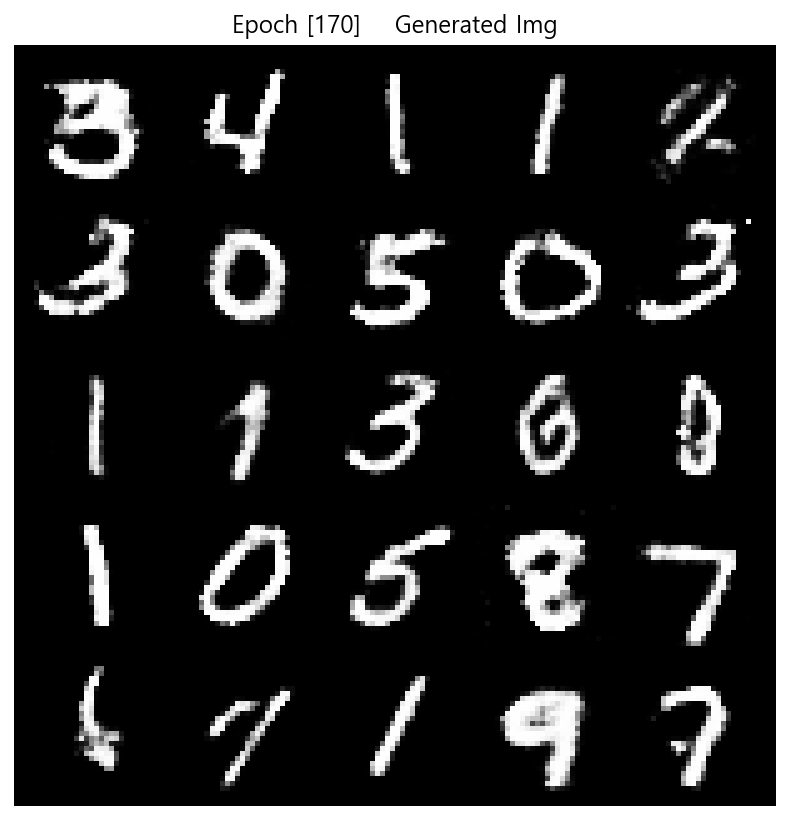

Epoch [171|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.709882 || 0.987500]    G_Loss -0.555432
Epoch [171|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.913688 || 3.115364]    G_Loss -2.839549
Epoch [171|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.378670 || 2.621703]    G_Loss -2.498491
Epoch [172|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.629466 || 1.614937]    G_Loss -1.570514
Epoch [172|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.054124 || 2.220866]    G_Loss -2.099143
Epoch [172|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.958165 || 2.029424]    G_Loss -1.865415
Epoch [173|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.266646 || 2.497673]    G_Loss -1.926206
Epoch [173|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.826121 || 1.961940]    G_Loss -1.773366
Epoch [173|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.278775 || 1.599095]    G_Loss -1.454531
Epoch [174

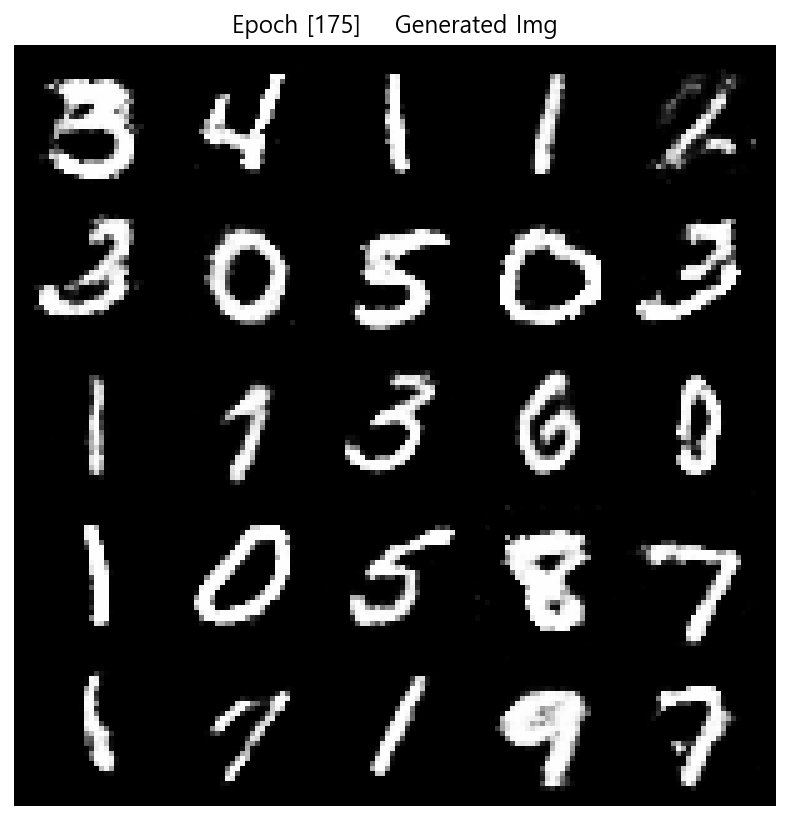

Epoch [176|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.977301 || 0.934838]    G_Loss -0.512472
Epoch [176|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.019366 || 0.130124]    G_Loss 0.094883
Epoch [176|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.751233 || 1.814277]    G_Loss -1.658741
Epoch [177|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.689521 || 2.071979]    G_Loss -1.927862
Epoch [177|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.203607 || 1.366017]    G_Loss -1.379694
Epoch [177|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.262419 || 2.398147]    G_Loss -2.267157
Epoch [178|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.809680 || 0.708751]    G_Loss -0.166185
Epoch [178|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.381952 || 2.633924]    G_Loss -2.550229
Epoch [178|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.077038 || 2.285001]    G_Loss -1.922973
Epoch [179|

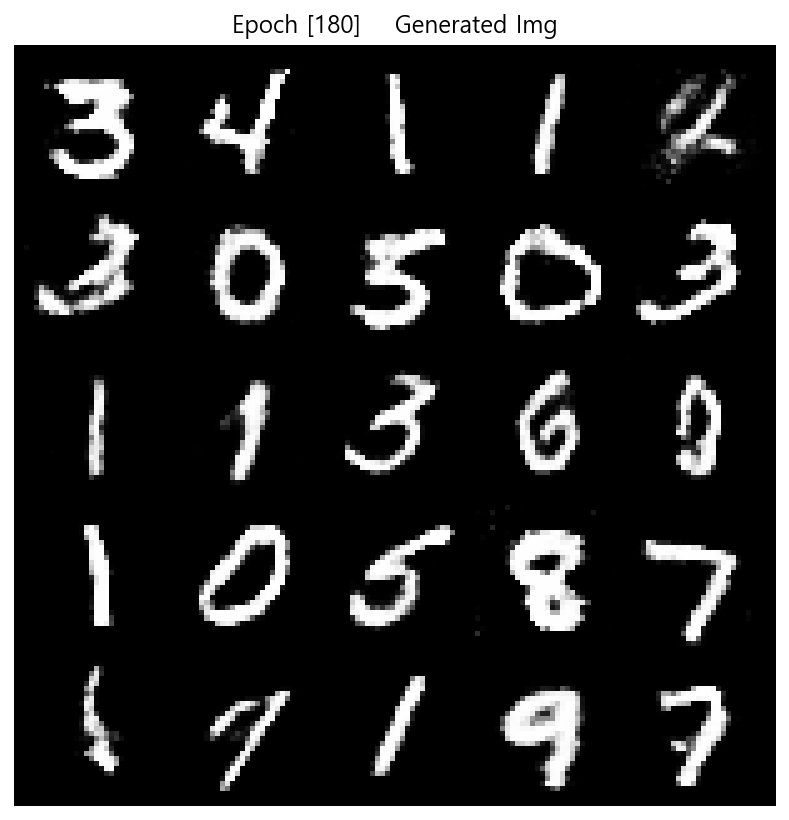

Epoch [181|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.025656 || 2.333388]    G_Loss -2.142386
Epoch [181|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.091924 || 1.983277]    G_Loss -1.757830
Epoch [181|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.275008 || 0.489343]    G_Loss -0.219976
Epoch [182|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.449941 || 1.451244]    G_Loss -1.187058
Epoch [182|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.748277 || 1.938233]    G_Loss -1.633646
Epoch [182|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.908002 || 2.082903]    G_Loss -1.827250
Epoch [183|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.768425 || 0.928225]    G_Loss -0.546540
Epoch [183|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.124852 || 1.272746]    G_Loss -1.128766
Epoch [183|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-1.784573 || 1.094105]    G_Loss -0.909110
Epoch [184

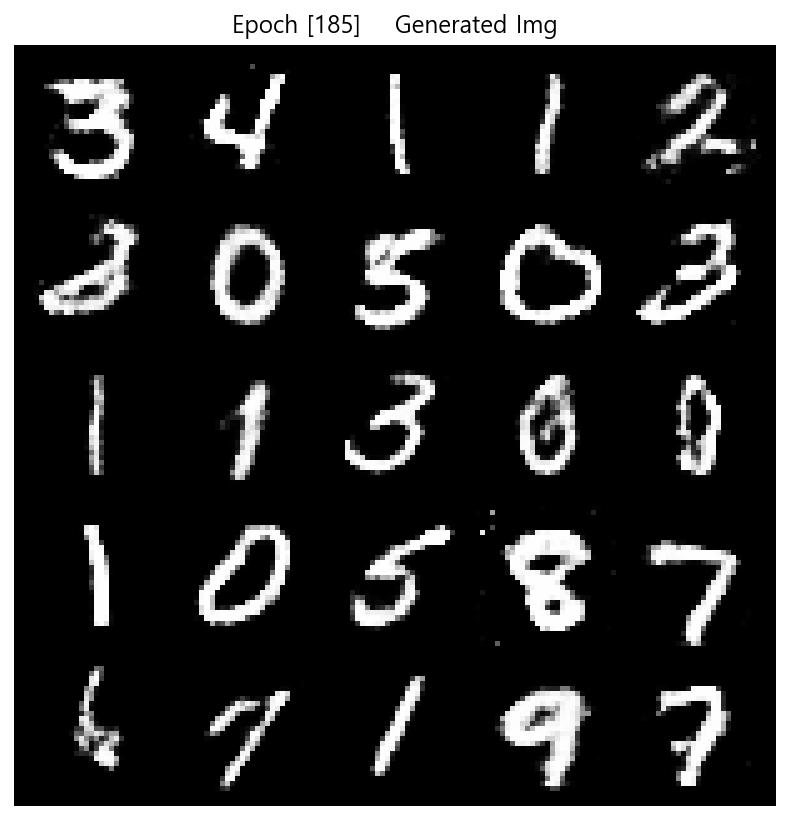

Epoch [186|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.973815 || 2.327034]    G_Loss -2.095971
Epoch [186|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-1.729498 || 1.011184]    G_Loss -1.087129
Epoch [186|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.416686 || 1.629977]    G_Loss -1.707877
Epoch [187|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.004228 || 2.409853]    G_Loss -2.466758
Epoch [187|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.683857 || 1.981389]    G_Loss -1.781352
Epoch [187|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.612400 || 2.703833]    G_Loss -2.445834
Epoch [188|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.909678 || 2.164422]    G_Loss -2.099511
Epoch [188|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.860825 || 1.922895]    G_Loss -1.718202
Epoch [188|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.318991 || 2.469390]    G_Loss -2.246308
Epoch [189

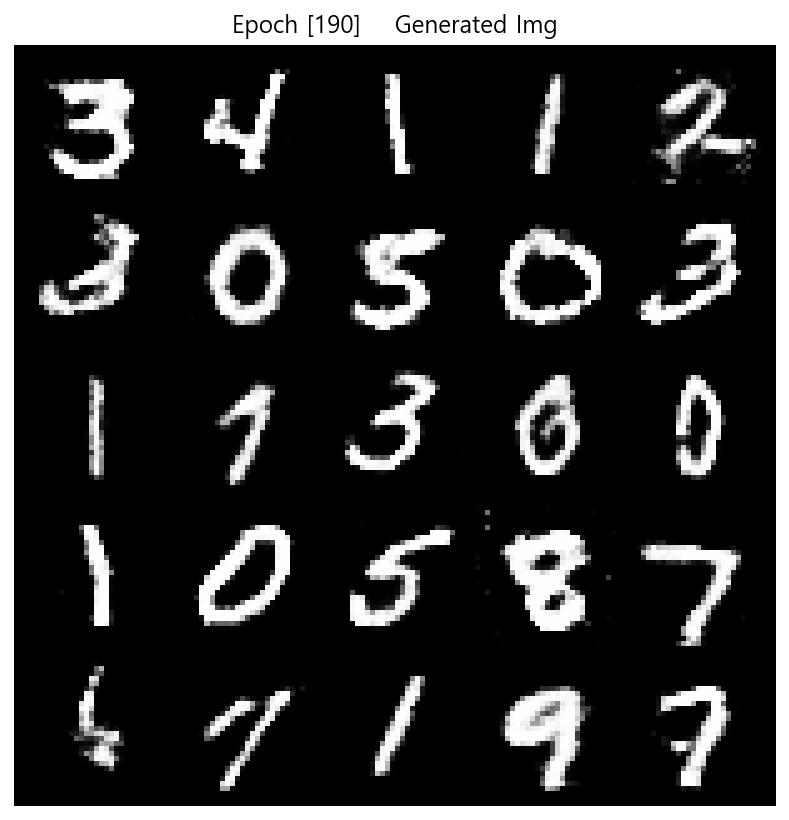

Epoch [191|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.717146 || 3.162498]    G_Loss -3.217123
Epoch [191|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-4.489388 || 3.547907]    G_Loss -3.348120
Epoch [191|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.265270 || 1.493884]    G_Loss -1.372951
Epoch [192|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.273474 || 3.470108]    G_Loss -3.443892
Epoch [192|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.518246 || 2.624797]    G_Loss -2.612071
Epoch [192|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.224585 || 2.475027]    G_Loss -2.504678
Epoch [193|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.711829 || 1.980252]    G_Loss -1.787708
Epoch [193|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-2.992955 || 2.166069]    G_Loss -1.926274
Epoch [193|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.220669 || 1.585008]    G_Loss -1.248196
Epoch [194

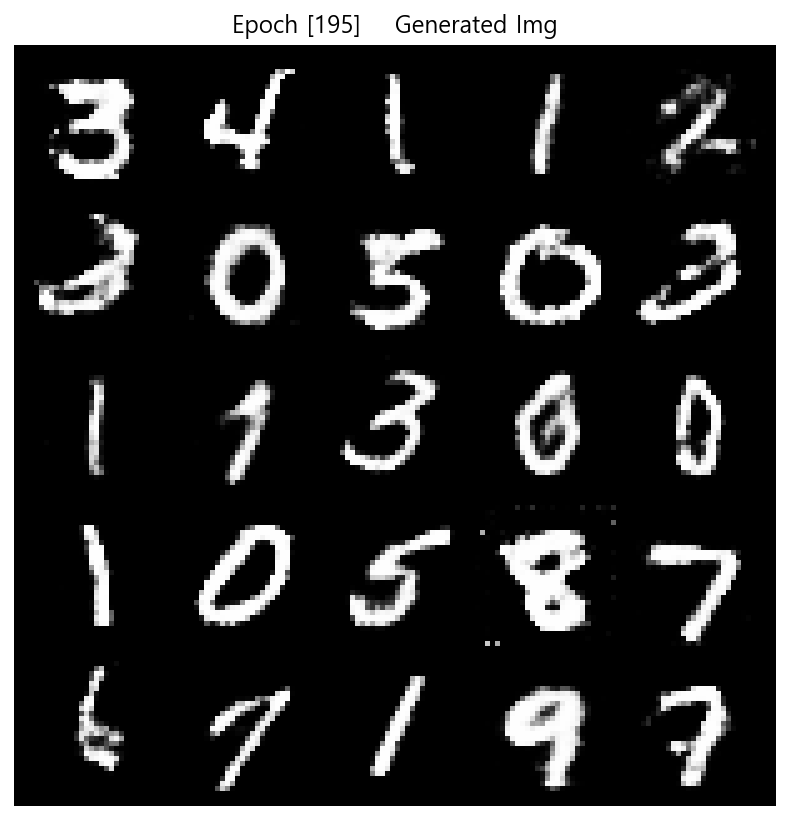

Epoch [196|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.136383 || 2.412511]    G_Loss -2.400243
Epoch [196|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-4.535406 || 3.585214]    G_Loss -3.374786
Epoch [196|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-3.818203 || 2.927775]    G_Loss -2.794282
Epoch [197|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.166384 || 2.432334]    G_Loss -1.980949
Epoch [197|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.427794 || 2.611660]    G_Loss -2.547599
Epoch [197|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.170612 || 1.596505]    G_Loss -1.239989
Epoch [198|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.496254 || 1.897902]    G_Loss -1.841156
Epoch [198|200]    Step [42.55%   100| 235]    D_Loss(Real||Fake) [-3.051675 || 2.349434]    G_Loss -2.116892
Epoch [198|200]    Step [85.11%   200| 235]    D_Loss(Real||Fake) [-2.863880 || 2.030974]    G_Loss -1.897305
Epoch [199

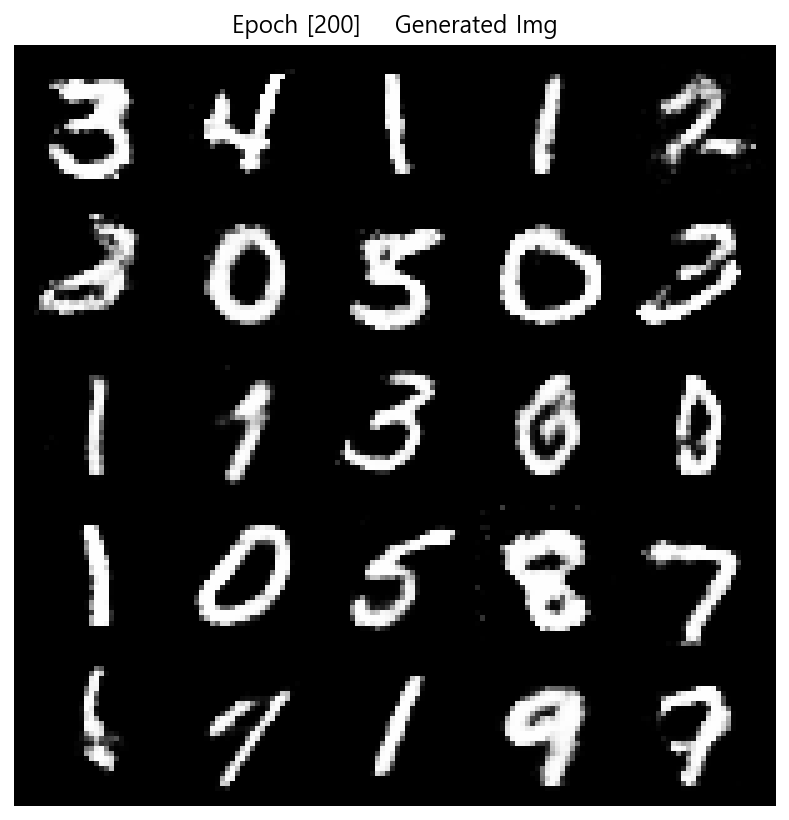

In [13]:
epochs = 200
test_batch_size = 25
random_fixed_latent = torch.randn((test_batch_size, latent_dim), dtype=torch.float).to(device)

for epoch in range(1, epochs+1):
    train(generator, discriminator, optimizer_G, optimizer_D, gp_coefficient, data_loader, epoch, epochs)
    if epoch % 5 == 0:
        test(generator, random_fixed_latent, epoch)